<a href="https://www.kaggle.com/code/dataranch/health-insurance-lead-prediction-28-models?scriptVersionId=110436577" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Insurance Lead Prediction | Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

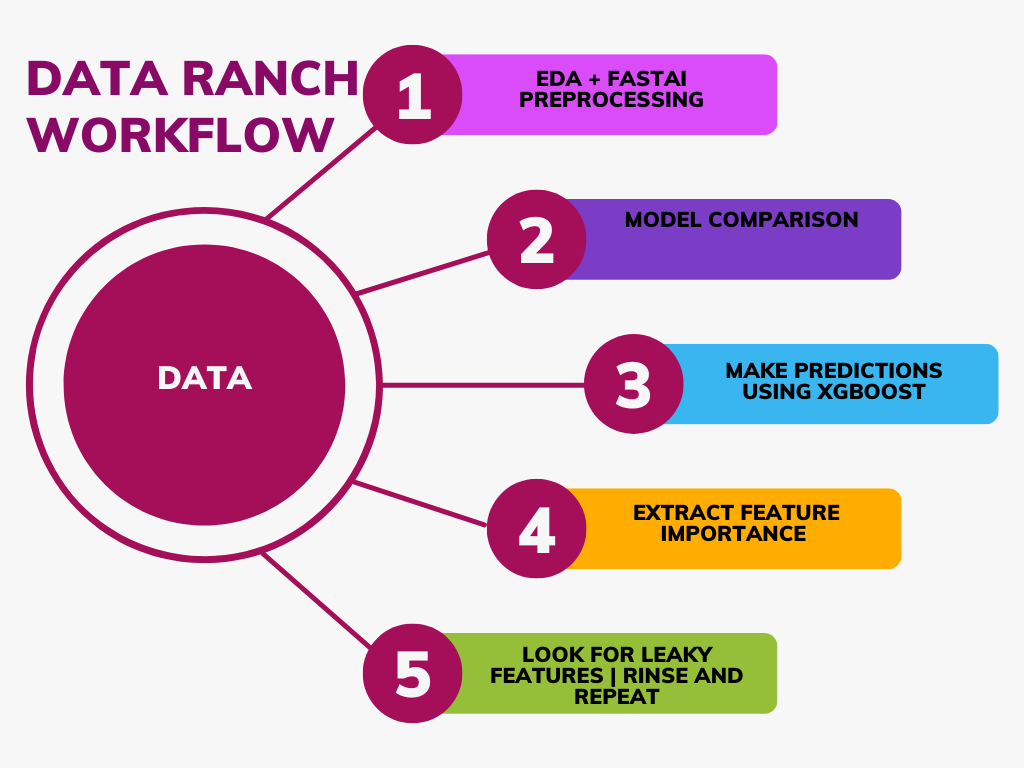

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.0 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'health-insurance-lead-prediction-raw-data'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 2500
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_COMMA = False
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/health-insurance-lead-prediction-raw-data
CSV!


In [12]:
df

ID City_Code  Region_Code Accomodation_Type Reco_Insurance_Type  \
0        1        C3         3213            Rented          Individual   
1        2        C5         1117             Owned               Joint   
2        3        C5         3732             Owned          Individual   
3        4       C24         4378             Owned               Joint   
4        5        C8         2190            Rented          Individual   
...    ...       ...          ...               ...                 ...   
2495  2496        C1          169             Owned          Individual   
2496  2497        C8         2046             Owned          Individual   
2497  2498        C7         3961             Owned          Individual   
2498  2499        C8         1409             Owned          Individual   
2499  2500       C11          374             Owned               Joint   

      Upper_Age  Lower_Age Is_Spouse Health Indicator Holding_Policy_Duration  \
0            36         36        No               X1                     14+   
1            75         22        No               X2                     NaN   
2            32         32        No              NaN                     1.0   
3            52         48        No               X1                     14+   
4            44         44        No               X2                     3.0   
...         ...        ...       ...              ...                     ...   
2495         31         31        No               X1                     9.0   
2496         29         29        No               X2                     4.0   
2497         75         75        No               X1                     6.0   
2498         32         32        No              NaN                     8.0   
2499         70         69       Yes              NaN                    12.0   

      Holding_Policy_Type  Reco_Policy_Cat  Reco_Policy_Premium  Response  
0                    3.00               22             11628.00         0  
1                     NaN               22             30510.00         0  
2                    1.00               19              7450.00         1  
3                    3.00               19             17780.00         0  
4                    1.00               16             10404.00         0  
...                   ...              ...                  ...       ...  
2495                 3.00               21             11124.00         0  
2496                 3.00               13              9184.00         0  
2497                 3.00               14             20988.00         0  
2498                 3.00               18             11394.00         0  
2499                 3.00               21             27193.60         0  

[2500 rows x 14 columns]

In [13]:
if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')


if SEP_COMMA:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str.replace('%', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')

In [14]:
df

ID City_Code  Region_Code Accomodation_Type Reco_Insurance_Type  \
0        1        C3         3213            Rented          Individual   
1        2        C5         1117             Owned               Joint   
2        3        C5         3732             Owned          Individual   
3        4       C24         4378             Owned               Joint   
4        5        C8         2190            Rented          Individual   
...    ...       ...          ...               ...                 ...   
2495  2496        C1          169             Owned          Individual   
2496  2497        C8         2046             Owned          Individual   
2497  2498        C7         3961             Owned          Individual   
2498  2499        C8         1409             Owned          Individual   
2499  2500       C11          374             Owned               Joint   

      Upper_Age  Lower_Age Is_Spouse Health Indicator Holding_Policy_Duration  \
0            36         36        No               X1                     14+   
1            75         22        No               X2                     NaN   
2            32         32        No              NaN                     1.0   
3            52         48        No               X1                     14+   
4            44         44        No               X2                     3.0   
...         ...        ...       ...              ...                     ...   
2495         31         31        No               X1                     9.0   
2496         29         29        No               X2                     4.0   
2497         75         75        No               X1                     6.0   
2498         32         32        No              NaN                     8.0   
2499         70         69       Yes              NaN                    12.0   

      Holding_Policy_Type  Reco_Policy_Cat  Reco_Policy_Premium  Response  
0                    3.00               22             11628.00         0  
1                     NaN               22             30510.00         0  
2                    1.00               19              7450.00         1  
3                    3.00               19             17780.00         0  
4                    1.00               16             10404.00         0  
...                   ...              ...                  ...       ...  
2495                 3.00               21             11124.00         0  
2496                 3.00               13              9184.00         0  
2497                 3.00               14             20988.00         0  
2498                 3.00               18             11394.00         0  
2499                 3.00               21             27193.60         0  

[2500 rows x 14 columns]

In [15]:
df.isna().sum()

ID                            0
City_Code                     0
Region_Code                   0
Accomodation_Type             0
Reco_Insurance_Type           0
Upper_Age                     0
Lower_Age                     0
Is_Spouse                     0
Health Indicator            582
Holding_Policy_Duration    1021
Holding_Policy_Type        1021
Reco_Policy_Cat               0
Reco_Policy_Premium           0
Response                      0
dtype: int64

In [16]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

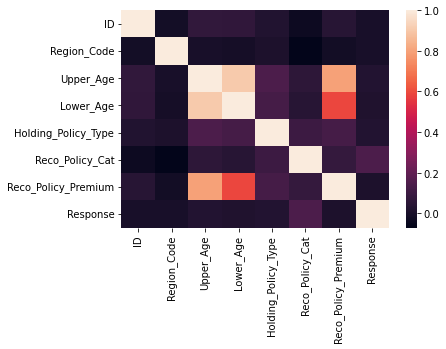

In [17]:
sns.heatmap(df.corr())

In [18]:
df.head().style.background_gradient(cmap = "inferno")

In [19]:
df.describe().T.style.background_gradient(cmap = "viridis")

In [20]:
df.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
      dtype='object')

In [21]:
# Remove features we don't want to train or predict on.
del(df['ID'])

Target Variable: Response
CATS=====================
['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
CONTS=====================
['Region_Code', 'Reco_Policy_Premium']
13
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Region_Code', 'Reco_Policy_Premium']
Categorical variables that made the cut : ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
Tabular Object size: 2500


  5%|▍         | 2/42 [00:00<00:02, 17.78it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.01533281115965246, 'Adjusted R-Squared': -0.00893003538261472, 'RMSE': 0.4330631033178513, 'Time taken': 0.025679349899291992}
{'Model': 'BaggingRegressor', 'R-Squared': -0.1040406586021505, 'Adjusted R-Squared': -0.13124494587776803, 'RMSE': 0.4585629727747324, 'Time taken': 0.08663797378540039}
{'Model': 'BayesianRidge', 'R-Squared': 0.0204782132820458, 'Adjusted R-Squared': -0.00365784717096318, 'RMSE': 0.4319301304440898, 'Time taken': 0.041632890701293945}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.9006216397849462, 'Adjusted R-Squared': -0.9474542058576758, 'RMSE': 0.6016643582596529, 'Time taken': 0.023016929626464844}
{'Model': 'DummyRegressor', 'R-Squared': -0.002100134408602017, 'Adjusted R-Squared': -0.02679254018458388, 'RMSE': 0.4368798461819908, 'Time taken': 0.00964498519897461}
{'Model': 'ElasticNet', 'R-Squared': -0.002100134408602017, 'Adjusted R-Squared': -0.02679254018458388, 'RMSE': 0.4368798461819908, 'Time tak

 17%|█▋        | 7/42 [00:00<00:01, 20.09it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.02649829609967136, 'Adjusted R-Squared': 0.0025105744429898547, 'RMSE': 0.4306007762785295, 'Time taken': 0.147413969039917}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.9741263440860215, 'Adjusted R-Squared': -1.0227701143715087, 'RMSE': 0.6131883886702356, 'Time taken': 0.02768421173095703}


 21%|██▏       | 9/42 [00:00<00:03,  9.83it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.016658266129032206, 'Adjusted R-Squared': -0.04170939383652361, 'RMSE': 0.4400418161947794, 'Time taken': 0.40671396255493164}
{'Model': 'GammaRegressor', 'R-Squared': 0.01503352892176335, 'Adjusted R-Squared': -0.009236692131499025, 'RMSE': 0.43312891146568044, 'Time taken': 0.01906132698059082}


 26%|██▌       | 11/42 [00:01<00:04,  7.69it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.345725462884971, 'Adjusted R-Squared': -1.4035256796295696, 'RMSE': 0.668413236376213, 'Time taken': 0.36823296546936035}


 29%|██▊       | 12/42 [00:01<00:04,  6.10it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.003469519175295366, 'Adjusted R-Squared': -0.028195667491729637, 'RMSE': 0.43717824568498764, 'Time taken': 0.31519556045532227}


 36%|███▌      | 15/42 [00:01<00:04,  6.70it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.05989337094669023, 'Adjusted R-Squared': -0.08600984004599255, 'RMSE': 0.44930115847167634, 'Time taken': 0.33849143981933594}
{'Model': 'HuberRegressor', 'R-Squared': -0.34408598401781165, 'Adjusted R-Squared': -0.377205145841659, 'RMSE': 0.5059644185710774, 'Time taken': 0.09135866165161133}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.07316868279569899, 'Adjusted R-Squared': -0.09961226430195835, 'RMSE': 0.45210618221829263, 'Time taken': 0.03246045112609863}


 48%|████▊     | 20/42 [00:02<00:02, 10.66it/s]

{'Model': 'KernelRidge', 'R-Squared': -8.252044778076478, 'Adjusted R-Squared': -8.48002124078062, 'RMSE': 1.3274718289333143, 'Time taken': 0.1600511074066162}
{'Model': 'Lars', 'R-Squared': 0.02621441174093364, 'Adjusted R-Squared': 0.002219694987116938, 'RMSE': 0.430663555785923, 'Time taken': 0.013830900192260742}
{'Model': 'LarsCV', 'R-Squared': 0.025467301205162385, 'Adjusted R-Squared': 0.0014541751568296624, 'RMSE': 0.43082873156657037, 'Time taken': 0.028561830520629883}
{'Model': 'Lasso', 'R-Squared': -0.002100134408602017, 'Adjusted R-Squared': -0.02679254018458388, 'RMSE': 0.4368798461819908, 'Time taken': 0.011625051498413086}
{'Model': 'LassoCV', 'R-Squared': 0.02672388352335786, 'Adjusted R-Squared': 0.0027417204890258784, 'RMSE': 0.4305508822991856, 'Time taken': 0.12336993217468262}


 55%|█████▍    | 23/42 [00:02<00:01, 13.43it/s]

{'Model': 'LassoLars', 'R-Squared': -0.002100134408602017, 'Adjusted R-Squared': -0.02679254018458388, 'RMSE': 0.4368798461819908, 'Time taken': 0.027114152908325195}
{'Model': 'LassoLarsCV', 'R-Squared': 0.025467301205162385, 'Adjusted R-Squared': 0.0014541751568296624, 'RMSE': 0.43082873156657037, 'Time taken': 0.05326414108276367}
{'Model': 'LassoLarsIC', 'R-Squared': 0.027783333027948554, 'Adjusted R-Squared': 0.003827275525557172, 'RMSE': 0.4303164826707952, 'Time taken': 0.03479170799255371}
{'Model': 'LinearRegression', 'R-Squared': 0.02621441174093364, 'Adjusted R-Squared': 0.002219694987116938, 'RMSE': 0.430663555785923, 'Time taken': 0.01962423324584961}
{'Model': 'LinearSVR', 'R-Squared': -0.344085898184292, 'Adjusted R-Squared': -0.3772050578931452, 'RMSE': 0.5059644024155978, 'Time taken': 0.04050707817077637}


 62%|██████▏   | 26/42 [00:04<00:04,  4.00it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.07167917037825444, 'Adjusted R-Squared': -0.09808604931981302, 'RMSE': 0.4517923212128819, 'Time taken': 1.6886019706726074}


 67%|██████▋   | 28/42 [00:04<00:03,  4.22it/s]

{'Model': 'NuSVR', 'R-Squared': -0.2870403668040047, 'Adjusted R-Squared': -0.3187538871359308, 'RMSE': 0.49511095364873314, 'Time taken': 0.3780670166015625}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.03136642983859461, 'Adjusted R-Squared': 0.007498662196013806, 'RMSE': 0.4295227867147701, 'Time taken': 0.011719703674316406}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.03136642983859461, 'Adjusted R-Squared': 0.007498662196013806, 'RMSE': 0.4295227867147701, 'Time taken': 0.019884586334228516}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.9999043138142822, 'Adjusted R-Squared': -1.0491832702121697, 'RMSE': 0.6171788843004299, 'Time taken': 0.015746116638183594}
{'Model': 'PoissonRegressor', 'R-Squared': 0.01628154413873928, 'Adjusted R-Squared': -0.007957924999525856, 'RMSE': 0.43285442353886044, 'Time taken': 0.021726608276367188}


 79%|███████▊  | 33/42 [00:49<00:37,  4.16s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.34408602138798305, 'Adjusted R-Squared': -0.377205184132656, 'RMSE': 0.5059644256048451, 'Time taken': 44.54406690597534}
{'Model': 'RANSACRegressor', 'R-Squared': -0.34408602150537626, 'Adjusted R-Squared': -0.3772051842529418, 'RMSE': 0.5059644256269407, 'Time taken': 0.16472792625427246}


 81%|████████  | 34/42 [00:50<00:29,  3.64s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.04767200100806446, 'Adjusted R-Squared': -0.07348732752161014, 'RMSE': 0.4467032572077351, 'Time taken': 0.7797324657440186}
{'Model': 'Ridge', 'R-Squared': 0.026190942077164325, 'Adjusted R-Squared': 0.002195647015410751, 'RMSE': 0.4306687455669554, 'Time taken': 0.011860847473144531}
{'Model': 'RidgeCV', 'R-Squared': 0.025995621517729606, 'Adjusted R-Squared': 0.0019955136290494835, 'RMSE': 0.4307119338296156, 'Time taken': 0.019108295440673828}
{'Model': 'SGDRegressor', 'R-Squared': 0.020788936666093938, 'Adjusted R-Squared': -0.0033394673585607215, 'RMSE': 0.4318616166862124, 'Time taken': 0.026862144470214844}


 90%|█████████ | 38/42 [00:50<00:07,  1.97s/it]

{'Model': 'SVR', 'R-Squared': -0.12954037929954776, 'Adjusted R-Squared': -0.15737299644861258, 'RMSE': 0.46382839370063267, 'Time taken': 0.26864051818847656}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.02621441174093364, 'Adjusted R-Squared': 0.002219694987116938, 'RMSE': 0.430663555785923, 'Time taken': 0.010625839233398438}
{'Model': 'TweedieRegressor', 'R-Squared': 0.014991107968557627, 'Adjusted R-Squared': -0.009280158364865843, 'RMSE': 0.4331382384549725, 'Time taken': 0.011591196060180664}


 98%|█████████▊| 41/42 [00:50<00:01,  1.36s/it]

{'Model': 'XGBRegressor', 'R-Squared': -0.1479930860630141, 'Adjusted R-Squared': -0.17628039003171248, 'RMSE': 0.46760172, 'Time taken': 0.48566746711730957}


100%|██████████| 42/42 [00:51<00:00,  1.22s/it]

{'Model': 'LGBMRegressor', 'R-Squared': -0.08446209471426558, 'Adjusted R-Squared': -0.1111839533109209, 'RMSE': 0.4544788096354525, 'Time taken': 0.21338391304016113}
Project: health-insurance-lead-prediction-raw-data
health-insurance-lead-prediction-raw-data
Target: Response
Response
Target Standard Deviation: 0.42462218500686
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
OrthogonalMatchingPursuitCV                  0.01       0.03  0.43        0.02
OrthogonalMatchingPursuit                    0.01       0.03  0.43        0.01
LassoLarsIC                                  0.00       0.03  0.43        0.03
LassoCV                                      0.00       0.03  0.43        0.12
ElasticNetCV                                 0.00       0.03  0.43        0.15
Lars                                         0.00       0.03  0.43        0.01
TransformedTargetRegressor           

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.4395136833190918.
Better model found at epoch 1 with _rmse value: 1.0581011772155762.
Better model found at epoch 2 with _rmse value: 0.911125123500824.
Better model found at epoch 3 with _rmse value: 0.7565743923187256.
Better model found at epoch 4 with _rmse value: 0.6356754302978516.
Better model found at epoch 5 with _rmse value: 0.5565381646156311.
Better model found at epoch 6 with _rmse value: 0.4611533284187317.
Better model found at epoch 7 with _rmse value: 0.4188663959503174.
Better model found at epoch 8 with _rmse value: 0.33605554699897766.
Better model found at epoch 9 with _rmse value: 0.32663029432296753.
Better model found at epoch 10 with _rmse value: 0.26694920659065247.
No improvement since epoch 10: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.44
1       2       1.78
2       1       1.20
3       2       1.23
4       1       1.39
XGBoost RMSE:  0.4676163


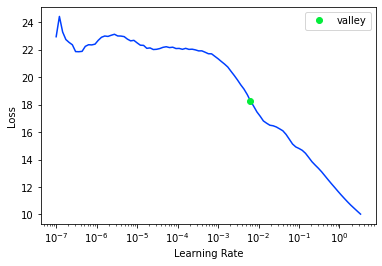

<Figure size 720x720 with 0 Axes>

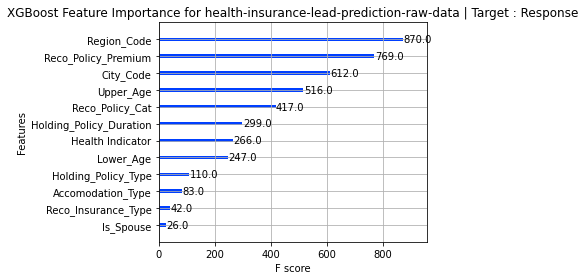

Target Variable: Reco_Policy_Premium
CATS=====================
['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
CONTS=====================
['Region_Code']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Region_Code']
Categorical variables that made the cut : ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
Tabular Object size: 2500


 10%|▉         | 4/42 [00:00<00:02, 17.44it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8144162515708859, 'Adjusted R-Squared': 0.8098433460654457, 'RMSE': 2892.102372762572, 'Time taken': 0.1298670768737793}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8034522797533018, 'Adjusted R-Squared': 0.7986092147780238, 'RMSE': 2976.3067958575984, 'Time taken': 0.08123254776000977}
{'Model': 'BayesianRidge', 'R-Squared': 0.8176620867325775, 'Adjusted R-Squared': 0.8131691607383084, 'RMSE': 2866.699566294358, 'Time taken': 0.014219045639038086}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.6456991660352249, 'Adjusted R-Squared': 0.6369689606808568, 'RMSE': 3996.0395496200463, 'Time taken': 0.024489164352416992}
{'Model': 'DummyRegressor', 'R-Squared': -0.00138578010719681, 'Adjusted R-Squared': -0.026060583723801267, 'RMSE': 6718.0684, 'Time taken': 0.019051790237426758}
{'Model': 'ElasticNet', 'R-Squared': 0.7550885466654007, 'Adjusted R-Squared': 0.7490537675277925, 'RMSE': 3322.371849360398, 'Time taken': 0.02591872215270996}


 17%|█▋        | 7/42 [00:00<00:01, 20.42it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.3946742529220284, 'Adjusted R-Squared': 0.37975862876404964, 'RMSE': 5223.219343233962, 'Time taken': 0.0782170295715332}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.6831585589639367, 'Adjusted R-Squared': 0.6753513776653068, 'RMSE': 3778.893744279328, 'Time taken': 0.017062902450561523}


 24%|██▍       | 10/42 [00:00<00:03,  9.51it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.7911177724134748, 'Adjusted R-Squared': 0.7859707770725337, 'RMSE': 3068.2760896671225, 'Time taken': 0.49994397163391113}
{'Model': 'GammaRegressor', 'R-Squared': 0.7082159060127009, 'Adjusted R-Squared': 0.7010261542101391, 'RMSE': 3626.3899072076374, 'Time taken': 0.015044450759887695}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.13320827479956332, 'Adjusted R-Squared': -0.16113127130386462, 'RMSE': 7146.584928514252, 'Time taken': 0.3547348976135254}


 29%|██▊       | 12/42 [00:01<00:05,  5.90it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8310203651116566, 'Adjusted R-Squared': 0.8268565958741615, 'RMSE': 2759.6936500441316, 'Time taken': 0.29148030281066895}


 33%|███▎      | 14/42 [00:01<00:04,  5.71it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8112133421207035, 'Adjusted R-Squared': 0.8065615148218297, 'RMSE': 2916.952382994261, 'Time taken': 0.35052013397216797}
{'Model': 'HuberRegressor', 'R-Squared': 0.816080161044771, 'Adjusted R-Squared': 0.811548255362096, 'RMSE': 2879.108154463613, 'Time taken': 0.026723384857177734}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7627490722073471, 'Adjusted R-Squared': 0.7569030534527027, 'RMSE': 3269.9993, 'Time taken': 0.032465219497680664}


 45%|████▌     | 19/42 [00:02<00:02,  9.45it/s]

{'Model': 'KernelRidge', 'R-Squared': -3.649329431662946, 'Adjusted R-Squared': -3.7638919638599795, 'RMSE': 14475.675878081736, 'Time taken': 0.14921355247497559}
{'Model': 'Lars', 'R-Squared': 0.8176270041300384, 'Adjusted R-Squared': 0.8131332136773906, 'RMSE': 2866.975335723104, 'Time taken': 0.024280071258544922}
{'Model': 'LarsCV', 'R-Squared': 0.8177497233832725, 'Adjusted R-Squared': 0.8132589568136611, 'RMSE': 2866.0105758971595, 'Time taken': 0.05737042427062988}
{'Model': 'Lasso', 'R-Squared': 0.8176457106610072, 'Adjusted R-Squared': 0.8131523811495741, 'RMSE': 2866.8282949345394, 'Time taken': 0.023347139358520508}


 50%|█████     | 21/42 [00:02<00:01, 10.80it/s]

{'Model': 'LassoCV', 'R-Squared': 0.8177596733073244, 'Adjusted R-Squared': 0.8132691519103796, 'RMSE': 2865.9323401399447, 'Time taken': 0.09552693367004395}
{'Model': 'LassoLars', 'R-Squared': 0.8170173157580733, 'Adjusted R-Squared': 0.8125085021833236, 'RMSE': 2871.7636078507066, 'Time taken': 0.013277530670166016}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8177497233832725, 'Adjusted R-Squared': 0.8132589568136611, 'RMSE': 2866.0105758971595, 'Time taken': 0.028850317001342773}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8177566591095042, 'Adjusted R-Squared': 0.8132660634407446, 'RMSE': 2865.9560408527614, 'Time taken': 0.014852046966552734}
{'Model': 'LinearRegression', 'R-Squared': 0.8176270041300386, 'Adjusted R-Squared': 0.8131332136773908, 'RMSE': 2866.9753357231025, 'Time taken': 0.011205911636352539}
{'Model': 'LinearSVR', 'R-Squared': -3.2072714216319724, 'Adjusted R-Squared': -3.310941353992513, 'RMSE': 13770.317561007592, 'Time taken': 0.023997068405151367}


 62%|██████▏   | 26/42 [00:03<00:03,  5.08it/s]

{'Model': 'MLPRegressor', 'R-Squared': -3.0511794322389276, 'Adjusted R-Squared': -3.1510031554152462, 'RMSE': 13512.460273198476, 'Time taken': 1.4427831172943115}
{'Model': 'NuSVR', 'R-Squared': 0.015481129660871118, 'Adjusted R-Squared': -0.00877806221606825, 'RMSE': 6661.249688402882, 'Time taken': 0.18881845474243164}


 67%|██████▋   | 28/42 [00:04<00:02,  5.68it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.628169722509638, 'Adjusted R-Squared': 0.6190075801484791, 'RMSE': 4093.700499548052, 'Time taken': 0.011536121368408203}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8156249478683774, 'Adjusted R-Squared': 0.8110818254339226, 'RMSE': 2882.6689394728633, 'Time taken': 0.017240047454833984}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8113550898877273, 'Adjusted R-Squared': 0.8067067553469731, 'RMSE': 2915.8571013337587, 'Time taken': 0.024407148361206055}
{'Model': 'PoissonRegressor', 'R-Squared': 0.832516088725236, 'Adjusted R-Squared': 0.8283891751003958, 'RMSE': 2747.4527850884174, 'Time taken': 0.020328044891357422}


 79%|███████▊  | 33/42 [01:17<00:57,  6.34s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.009952307234467161, 'Adjusted R-Squared': -0.03483819570841695, 'RMSE': 6746.742320941559, 'Time taken': 73.47587466239929}
{'Model': 'RANSACRegressor', 'R-Squared': 0.7695069286185139, 'Adjusted R-Squared': 0.7638274278863212, 'RMSE': 3223.091450068547, 'Time taken': 0.14742660522460938}


 81%|████████  | 34/42 [01:18<00:44,  5.51s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8140090767177913, 'Adjusted R-Squared': 0.8094261381564227, 'RMSE': 2895.273302763054, 'Time taken': 0.7291171550750732}
{'Model': 'Ridge', 'R-Squared': 0.8176462139177252, 'Adjusted R-Squared': 0.8131528968068683, 'RMSE': 2866.824339031995, 'Time taken': 0.010129213333129883}
{'Model': 'RidgeCV', 'R-Squared': 0.8176462139184266, 'Adjusted R-Squared': 0.8131528968075871, 'RMSE': 2866.824339026482, 'Time taken': 0.027556419372558594}
{'Model': 'SGDRegressor', 'R-Squared': 0.8176405323465256, 'Adjusted R-Squared': 0.8131470752380211, 'RMSE': 2866.8689993049725, 'Time taken': 0.02169203758239746}


 90%|█████████ | 38/42 [01:18<00:12,  3.03s/it]

{'Model': 'SVR', 'R-Squared': 0.014268167671572018, 'Adjusted R-Squared': -0.010020912385801939, 'RMSE': 6665.351872619797, 'Time taken': 0.24823760986328125}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8176270041300386, 'Adjusted R-Squared': 0.8131332136773908, 'RMSE': 2866.9753357231025, 'Time taken': 0.014090776443481445}
{'Model': 'TweedieRegressor', 'R-Squared': 0.698349417279525, 'Adjusted R-Squared': 0.6909165487114641, 'RMSE': 3687.192187174576, 'Time taken': 0.01891613006591797}


100%|██████████| 42/42 [01:19<00:00,  1.89s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.7774385099148229, 'Adjusted R-Squared': 0.771954448557488, 'RMSE': 3167.1504, 'Time taken': 0.46891093254089355}
{'Model': 'LGBMRegressor', 'R-Squared': 0.8187224775805365, 'Adjusted R-Squared': 0.8142556803135271, 'RMSE': 2858.3517291163844, 'Time taken': 0.11284565925598145}
Project: health-insurance-lead-prediction-raw-data
health-insurance-lead-prediction-raw-data
Target: Reco_Policy_Premium
Reco_Policy_Premium
Target Standard Deviation: 6765.6435546875
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
PoissonRegressor                             0.83       0.83  2747.45   
GradientBoostingRegressor                    0.83       0.83  2759.69   
LGBMRegressor                                0.81       0.82  2858.35   
LassoCV                                      0.81       0.82  2865.93   
LassoLarsIC                                  0.81       0.8

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 15533.0625.
Better model found at epoch 1 with _rmse value: 15217.6181640625.
Better model found at epoch 2 with _rmse value: 11330.203125.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

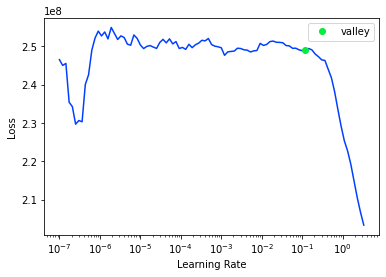

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
    actual  predicted
0  6480.00    7617.41
1 13332.00   15213.47
2  7140.00   10508.96
3  5352.00   10048.76
4 10936.80   13517.16
XGBoost RMSE:  3166.4597


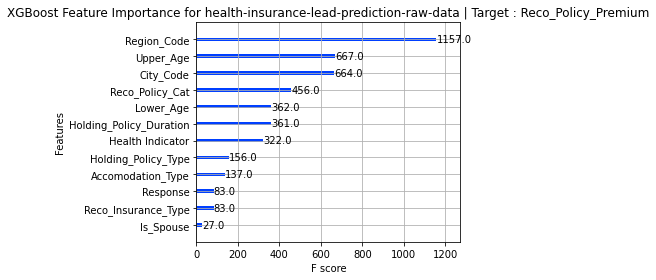

Target Variable: Reco_Policy_Cat
CATS=====================
['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
CONTS=====================
['Region_Code', 'Reco_Policy_Premium']
13
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Region_Code', 'Reco_Policy_Premium']
Categorical variables that made the cut : ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
Tabular Object size: 2500


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.0010021442164551697, 'Adjusted R-Squared': -0.02566749479263053, 'RMSE': 6.4039876521233365, 'Time taken': 0.03230571746826172}


  5%|▍         | 2/42 [00:00<00:02, 15.65it/s]

{'Model': 'BaggingRegressor', 'R-Squared': -0.14116377837442018, 'Adjusted R-Squared': -0.16928280371424154, 'RMSE': 6.837651643656614, 'Time taken': 0.09506082534790039}
{'Model': 'BayesianRidge', 'R-Squared': 0.01058875757964406, 'Adjusted R-Squared': -0.013790985560077074, 'RMSE': 6.366802855591022, 'Time taken': 0.019977569580078125}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.9792531120331951, 'Adjusted R-Squared': -1.0280232092496187, 'RMSE': 9.004998611882181, 'Time taken': 0.02641582489013672}
{'Model': 'DummyRegressor', 'R-Squared': -0.00018052233341481205, 'Adjusted R-Squared': -0.024825627606517298, 'RMSE': 6.401358918229785, 'Time taken': 0.013833045959472656}
{'Model': 'ElasticNet', 'R-Squared': 0.010376880090414708, 'Adjusted R-Squared': -0.014008083849862407, 'RMSE': 6.367484528657743, 'Time taken': 0.012333393096923828}


 17%|█▋        | 7/42 [00:00<00:01, 22.90it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.014122755339795345, 'Adjusted R-Squared': -0.010169907772981768, 'RMSE': 6.35542215070947, 'Time taken': 0.11609077453613281}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.8556992921649988, 'Adjusted R-Squared': -0.9014249420746085, 'RMSE': 8.719403649332907, 'Time taken': 0.029988527297973633}


 24%|██▍       | 10/42 [00:00<00:03,  9.86it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.04559263851598727, 'Adjusted R-Squared': -0.07135672817141203, 'RMSE': 6.54506916693781, 'Time taken': 0.5144820213317871}
{'Model': 'GammaRegressor', 'R-Squared': 0.012084333924007762, 'Adjusted R-Squared': -0.01225855723186875, 'RMSE': 6.361989063110169, 'Time taken': 0.013427734375}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -2.348595595473274, 'Adjusted R-Squared': -2.431107191254956, 'RMSE': 11.712897231109817, 'Time taken': 0.36083149909973145}


 29%|██▊       | 12/42 [00:01<00:04,  6.09it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.03496849684850578, 'Adjusted R-Squared': 0.011189486503910495, 'RMSE': 6.287872508576864, 'Time taken': 0.29549193382263184}


 38%|███▊      | 16/42 [00:02<00:03,  7.22it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.004042346198352753, 'Adjusted R-Squared': -0.028782609349030874, 'RMSE': 6.413705241414398, 'Time taken': 0.34322142601013184}
{'Model': 'HuberRegressor', 'R-Squared': -0.02668002337973152, 'Adjusted R-Squared': -0.05197809377101836, 'RMSE': 6.485605643104397, 'Time taken': 0.026227474212646484}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.16763876006834288, 'Adjusted R-Squared': -0.19641014635339427, 'RMSE': 6.916513572602891, 'Time taken': 0.027883052825927734}
{'Model': 'KernelRidge', 'R-Squared': -5.5930500681269395, 'Adjusted R-Squared': -5.755507153994543, 'RMSE': 16.43524448528712, 'Time taken': 0.12464761734008789}
{'Model': 'Lars', 'R-Squared': 0.006762807261797454, 'Adjusted R-Squared': -0.017711209807727002, 'RMSE': 6.3791008603473385, 'Time taken': 0.013088464736938477}


 48%|████▊     | 20/42 [00:02<00:02,  9.96it/s]

{'Model': 'LarsCV', 'R-Squared': 0.015141078399510621, 'Adjusted R-Squared': -0.00912649256395115, 'RMSE': 6.352139011228584, 'Time taken': 0.03940606117248535}
{'Model': 'Lasso', 'R-Squared': -0.00018052233341481205, 'Adjusted R-Squared': -0.024825627606517298, 'RMSE': 6.401358918229785, 'Time taken': 0.01931452751159668}
{'Model': 'LassoCV', 'R-Squared': 0.01433859072216026, 'Adjusted R-Squared': -0.009948754064973198, 'RMSE': 6.354726425119581, 'Time taken': 0.12848854064941406}
{'Model': 'LassoLars', 'R-Squared': -0.00018052233341481205, 'Adjusted R-Squared': -0.024825627606517298, 'RMSE': 6.401358918229785, 'Time taken': 0.012698173522949219}
{'Model': 'LassoLarsCV', 'R-Squared': 0.015141078399510621, 'Adjusted R-Squared': -0.00912649256395115, 'RMSE': 6.352139011228584, 'Time taken': 0.028778553009033203}


 60%|█████▉    | 25/42 [00:02<00:01, 15.14it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.009318161106301237, 'Adjusted R-Squared': -0.015092890365411948, 'RMSE': 6.370889650549194, 'Time taken': 0.018131732940673828}
{'Model': 'LinearRegression', 'R-Squared': 0.006762807261797121, 'Adjusted R-Squared': -0.017711209807727224, 'RMSE': 6.379100860347339, 'Time taken': 0.01182413101196289}
{'Model': 'LinearSVR', 'R-Squared': -0.05603422340263098, 'Adjusted R-Squared': -0.08205560057066297, 'RMSE': 6.577668441994153, 'Time taken': 0.0366978645324707}
{'Model': 'MLPRegressor', 'R-Squared': -0.026091200042778873, 'Adjusted R-Squared': -0.05137476144013675, 'RMSE': 6.483745558375394, 'Time taken': 1.6142051219940186}
{'Model': 'NuSVR', 'R-Squared': -0.007571694367150439, 'Adjusted R-Squared': -0.032398922975786615, 'RMSE': 6.424967884606285, 'Time taken': 0.1939396858215332}


 67%|██████▋   | 28/42 [00:04<00:03,  4.66it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.014721137316837551, 'Adjusted R-Squared': -0.009556781270837922, 'RMSE': 6.353493134027073, 'Time taken': 0.010832786560058594}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.00788417050119028, 'Adjusted R-Squared': -0.016562215441285444, 'RMSE': 6.3754988459387425, 'Time taken': 0.016268014907836914}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.4786132158198102, 'Adjusted R-Squared': -0.5150472170309759, 'RMSE': 7.783237337518214, 'Time taken': 0.009973526000976562}
{'Model': 'PoissonRegressor', 'R-Squared': 0.010028506896649692, 'Adjusted R-Squared': -0.01436504118803228, 'RMSE': 6.368605190498487, 'Time taken': 0.018126249313354492}


 79%|███████▊  | 33/42 [00:49<00:32,  3.58s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.08811325359765276, 'Adjusted R-Squared': -0.11492507914831362, 'RMSE': 6.676825593041639, 'Time taken': 45.05246353149414}
{'Model': 'RANSACRegressor', 'R-Squared': -0.36264119033200326, 'Adjusted R-Squared': -0.39621756463176494, 'RMSE': 7.471774191442229, 'Time taken': 0.12737274169921875}


 83%|████████▎ | 35/42 [00:50<00:19,  2.84s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.006795630949475218, 'Adjusted R-Squared': -0.03160373684556084, 'RMSE': 6.422493051767359, 'Time taken': 0.8733198642730713}
{'Model': 'Ridge', 'R-Squared': 0.006800723507302431, 'Adjusted R-Squared': -0.017672359281018624, 'RMSE': 6.378979099974057, 'Time taken': 0.009835481643676758}
{'Model': 'RidgeCV', 'R-Squared': 0.0071296888908608524, 'Adjusted R-Squared': -0.017335287974251434, 'RMSE': 6.377922596436981, 'Time taken': 0.026844024658203125}
{'Model': 'SGDRegressor', 'R-Squared': 0.00011453239369652035, 'Adjusted R-Squared': -0.024523302537054148, 'RMSE': 6.400414643429772, 'Time taken': 0.015557527542114258}


 90%|█████████ | 38/42 [00:50<00:07,  1.91s/it]

{'Model': 'SVR', 'R-Squared': -0.06352404619263075, 'Adjusted R-Squared': -0.08972997751565237, 'RMSE': 6.600952974572087, 'Time taken': 0.24663543701171875}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.006762807261797121, 'Adjusted R-Squared': -0.017711209807727224, 'RMSE': 6.379100860347339, 'Time taken': 0.01351785659790039}
{'Model': 'TweedieRegressor', 'R-Squared': 0.012591704290485617, 'Adjusted R-Squared': -0.011738684926175802, 'RMSE': 6.360355168952345, 'Time taken': 0.014829397201538086}


100%|██████████| 42/42 [00:51<00:00,  1.22s/it]

{'Model': 'XGBRegressor', 'R-Squared': -0.11743267627291054, 'Adjusted R-Squared': -0.14496695166361873, 'RMSE': 6.766182, 'Time taken': 0.44736146926879883}
{'Model': 'LGBMRegressor', 'R-Squared': -0.03544551495114234, 'Adjusted R-Squared': -0.060959572814414775, 'RMSE': 6.513232895233235, 'Time taken': 0.08623647689819336}
Project: health-insurance-lead-prediction-raw-data
health-insurance-lead-prediction-raw-data
Target: Reco_Policy_Cat
Reco_Policy_Cat
Target Standard Deviation: 6.5006771954927896
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.01       0.03  6.29        0.30
LarsCV                                      -0.01       0.02  6.35        0.04
LassoLarsCV                                 -0.01       0.02  6.35        0.03
OrthogonalMatchingPursuit                   -0.01       0.01  6.35        0.01
LassoCV             

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 10.143488883972168.
Better model found at epoch 1 with _rmse value: 8.940299987792969.
Better model found at epoch 2 with _rmse value: 7.226564884185791.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0      10      20.64
1      16      17.73
2      20      19.91
3      18      14.95
4       9      10.56
XGBoost RMSE:  6.7632732


<Figure size 432x288 with 0 Axes>

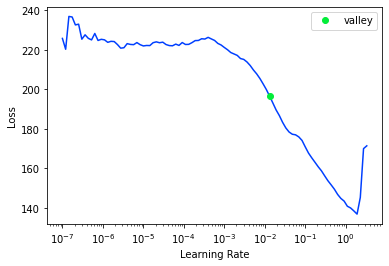

<Figure size 720x720 with 0 Axes>

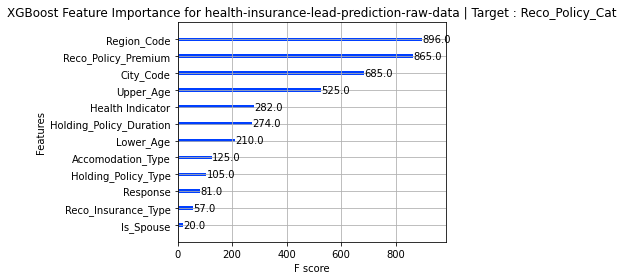

Target Variable: Holding_Policy_Type
CATS=====================
['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
CONTS=====================
['Region_Code', 'Reco_Policy_Premium']
13
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Region_Code', 'Reco_Policy_Premium']
Categorical variables that made the cut : ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
Tabular Object size: 2500


 14%|█▍        | 6/42 [00:00<00:01, 25.97it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.709128595385198, 'Adjusted R-Squared': 0.7019613328484884, 'RMSE': 0.7696875686046811, 'Time taken': 0.05830264091491699}
{'Model': 'BaggingRegressor', 'R-Squared': 0.6976389303502128, 'Adjusted R-Squared': 0.6901885549173639, 'RMSE': 0.7847419958177336, 'Time taken': 0.0646219253540039}
{'Model': 'BayesianRidge', 'R-Squared': 0.44975780932161136, 'Adjusted R-Squared': 0.4361994801878524, 'RMSE': 1.0586219678069395, 'Time taken': 0.026644468307495117}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.4608936791993338, 'Adjusted R-Squared': 0.4476097452165658, 'RMSE': 1.047854951794379, 'Time taken': 0.04053044319152832}
{'Model': 'DummyRegressor', 'R-Squared': -0.0010164707291782094, 'Adjusted R-Squared': -0.02568217432004083, 'RMSE': 1.4278565229041746, 'Time taken': 0.0298311710357666}
{'Model': 'ElasticNet', 'R-Squared': 0.2413889475276213, 'Adjusted R-Squared': 0.2226962727233739, 'RMSE': 1.2430069046528678, 'Time taken': 0.023574829101

 21%|██▏       | 9/42 [00:00<00:03, 10.01it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.7052778410608512, 'Adjusted R-Squared': 0.6980156934073198, 'RMSE': 0.774765641984723, 'Time taken': 0.35099363327026367}
{'Model': 'GammaRegressor', 'R-Squared': 0.3464983695417889, 'Adjusted R-Squared': 0.33039565996170983, 'RMSE': 1.153685132417316, 'Time taken': 0.014483451843261719}


 26%|██▌       | 11/42 [00:01<00:03,  7.89it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.09009237593865871, 'Adjusted R-Squared': 0.06767165419587418, 'RMSE': 1.3613274762364234, 'Time taken': 0.36541104316711426}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7338601643524969, 'Adjusted R-Squared': 0.7273023039258644, 'RMSE': 0.7362391376601843, 'Time taken': 0.3221457004547119}


 38%|███▊      | 16/42 [00:02<00:03,  7.10it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7085700089795798, 'Adjusted R-Squared': 0.7013889825067974, 'RMSE': 0.7704262641104948, 'Time taken': 0.3447227478027344}
{'Model': 'HuberRegressor', 'R-Squared': 0.40978827371429516, 'Adjusted R-Squared': 0.39524506895982203, 'RMSE': 1.096397092194703, 'Time taken': 0.026093482971191406}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.3995003692240011, 'Adjusted R-Squared': 0.3847036637428677, 'RMSE': 1.105911388855364, 'Time taken': 0.031177520751953125}
{'Model': 'KernelRidge', 'R-Squared': -2.4994493517327676, 'Adjusted R-Squared': -2.5856780831923016, 'RMSE': 2.669708315991006, 'Time taken': 0.13874030113220215}


 48%|████▊     | 20/42 [00:02<00:02, 10.27it/s]

{'Model': 'Lars', 'R-Squared': 0.4491961510443241, 'Adjusted R-Squared': 0.43562398228155597, 'RMSE': 1.059162122804352, 'Time taken': 0.013948440551757812}
{'Model': 'LarsCV', 'R-Squared': 0.4501273080077841, 'Adjusted R-Squared': 0.43657808356444416, 'RMSE': 1.058266465154837, 'Time taken': 0.030131101608276367}
{'Model': 'Lasso', 'R-Squared': -0.0010164707291782094, 'Adjusted R-Squared': -0.02568217432004083, 'RMSE': 1.4278565229041746, 'Time taken': 0.011778831481933594}
{'Model': 'LassoCV', 'R-Squared': 0.4498287147320863, 'Adjusted R-Squared': 0.43627213275423216, 'RMSE': 1.0585537574399804, 'Time taken': 0.09317541122436523}
{'Model': 'LassoLars', 'R-Squared': -0.0010164707291782094, 'Adjusted R-Squared': -0.02568217432004083, 'RMSE': 1.4278565229041746, 'Time taken': 0.02577495574951172}


 60%|█████▉    | 25/42 [00:02<00:01, 15.05it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.44984099259093, 'Adjusted R-Squared': 0.43628471314758543, 'RMSE': 1.0585419458037941, 'Time taken': 0.03491401672363281}
{'Model': 'LassoLarsIC', 'R-Squared': 0.4497776442210747, 'Adjusted R-Squared': 0.43621980383227166, 'RMSE': 1.0586028872548763, 'Time taken': 0.015603065490722656}
{'Model': 'LinearRegression', 'R-Squared': 0.4491961510443243, 'Adjusted R-Squared': 0.4356239822815562, 'RMSE': 1.0591621228043517, 'Time taken': 0.01124715805053711}
{'Model': 'LinearSVR', 'R-Squared': 0.3448655173808811, 'Adjusted R-Squared': 0.3287225732506359, 'RMSE': 1.1551255435182315, 'Time taken': 0.03264951705932617}
{'Model': 'MLPRegressor', 'R-Squared': 0.656886192480097, 'Adjusted R-Squared': 0.6484316428081487, 'RMSE': 0.8359553003785646, 'Time taken': 1.61918044090271}


 67%|██████▋   | 28/42 [00:04<00:03,  4.63it/s]

{'Model': 'NuSVR', 'R-Squared': 0.5121445582224746, 'Adjusted R-Squared': 0.5001234795749792, 'RMSE': 0.9968034558979283, 'Time taken': 0.22505807876586914}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.4300646115351128, 'Adjusted R-Squared': 0.4160210290678056, 'RMSE': 1.0773995013122986, 'Time taken': 0.011923074722290039}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.4494796321741298, 'Adjusted R-Squared': 0.43591444857267103, 'RMSE': 1.0588895292864224, 'Time taken': 0.020320415496826172}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.25113388035428197, 'Adjusted R-Squared': -0.2819626412665024, 'RMSE': 1.596304914060308, 'Time taken': 0.012824535369873047}
{'Model': 'PoissonRegressor', 'R-Squared': 0.39289009911843054, 'Adjusted R-Squared': 0.3779305122383919, 'RMSE': 1.1119816381420586, 'Time taken': 0.013134002685546875}


 79%|███████▊  | 33/42 [00:49<00:32,  3.57s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.10570804595227834, 'Adjusted R-Squared': -0.13295341874781696, 'RMSE': 1.5006665185920518, 'Time taken': 45.10054421424866}
{'Model': 'RANSACRegressor', 'R-Squared': 0.3317534911840432, 'Adjusted R-Squared': 0.31528745811260284, 'RMSE': 1.1666277630381914, 'Time taken': 0.18510127067565918}


 83%|████████▎ | 35/42 [00:50<00:19,  2.79s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.729936799849168, 'Adjusted R-Squared': 0.7232822651431927, 'RMSE': 0.7416460072028973, 'Time taken': 0.5708234310150146}
{'Model': 'Ridge', 'R-Squared': 0.4492469528654537, 'Adjusted R-Squared': 0.43567603589293924, 'RMSE': 1.059113277280159, 'Time taken': 0.010173797607421875}
{'Model': 'RidgeCV', 'R-Squared': 0.44963925377465297, 'Adjusted R-Squared': 0.4360780033543159, 'RMSE': 1.05873600735979, 'Time taken': 0.023317575454711914}
{'Model': 'SGDRegressor', 'R-Squared': 0.4496289699335607, 'Adjusted R-Squared': 0.4360674661126218, 'RMSE': 1.0587458988919094, 'Time taken': 0.013767242431640625}


 90%|█████████ | 38/42 [00:50<00:07,  1.88s/it]

{'Model': 'SVR', 'R-Squared': 0.4941420434311272, 'Adjusted R-Squared': 0.4816773709900052, 'RMSE': 1.015028533380047, 'Time taken': 0.22060513496398926}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.4491961510443243, 'Adjusted R-Squared': 0.4356239822815562, 'RMSE': 1.0591621228043517, 'Time taken': 0.010769128799438477}
{'Model': 'TweedieRegressor', 'R-Squared': 0.364794845936248, 'Adjusted R-Squared': 0.34914297355685375, 'RMSE': 1.1374202732949066, 'Time taken': 0.011391401290893555}


100%|██████████| 42/42 [00:50<00:00,  1.21s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.6764151747594382, 'Adjusted R-Squared': 0.6684418320430383, 'RMSE': 0.8118168, 'Time taken': 0.47332119941711426}
{'Model': 'LGBMRegressor', 'R-Squared': 0.7080084848454812, 'Adjusted R-Squared': 0.7008136220490659, 'RMSE': 0.7711681313963052, 'Time taken': 0.10455965995788574}
Project: health-insurance-lead-prediction-raw-data
health-insurance-lead-prediction-raw-data
Target: Holding_Policy_Type
Holding_Policy_Type
Target Standard Deviation: 1.4206891813482638
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.73       0.73  0.74        0.32
RandomForestRegressor                        0.72       0.73  0.74        0.57
AdaBoostRegressor                            0.70       0.71  0.77        0.06
HistGradientBoostingRegressor                0.70       0.71  0.77        0.34
LGBMRegressor      

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.399768114089966.
Better model found at epoch 1 with _rmse value: 2.182016372680664.
Better model found at epoch 2 with _rmse value: 1.9660757780075073.
Better model found at epoch 3 with _rmse value: 1.7580174207687378.
Better model found at epoch 4 with _rmse value: 1.694066047668457.
Better model found at epoch 5 with _rmse value: 1.3749995231628418.
No improvement since epoch 5: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       0.93
1       1       0.90
2       2       2.04
3       1       0.99
4       4       3.27
XGBoost RMSE:  0.8118184


<Figure size 432x288 with 0 Axes>

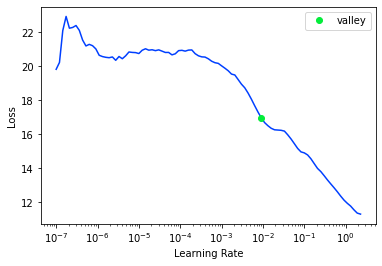

<Figure size 720x720 with 0 Axes>

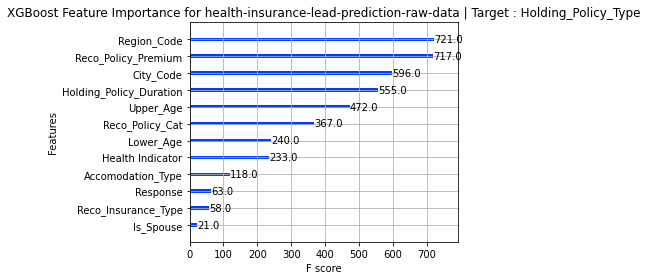

Target Variable: Holding_Policy_Duration
CATS=====================
['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
CONTS=====================
['Region_Code', 'Reco_Policy_Premium']
13
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Region_Code', 'Reco_Policy_Premium']
Categorical variables that made the cut : ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
Tabular Object size: 2500


  5%|▍         | 2/42 [00:00<00:02, 16.91it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.29147296026878455, 'Adjusted R-Squared': 0.2740143884478923, 'RMSE': 3.004645208705721, 'Time taken': 0.045430898666381836}
{'Model': 'BaggingRegressor', 'R-Squared': 0.1734731484841674, 'Adjusted R-Squared': 0.15310698376509146, 'RMSE': 3.2452149389524263, 'Time taken': 0.07263064384460449}
{'Model': 'BayesianRidge', 'R-Squared': 0.2322053243765353, 'Adjusted R-Squared': 0.21328635906343152, 'RMSE': 3.127789598228571, 'Time taken': 0.020344972610473633}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.45191690703085663, 'Adjusted R-Squared': -0.4876930936517401, 'RMSE': 4.301162633521313, 'Time taken': 0.02280735969543457}
{'Model': 'DummyRegressor', 'R-Squared': -0.0001808225164217081, 'Adjusted R-Squared': -0.024825935186230774, 'RMSE': 3.569885152214284, 'Time taken': 0.011538505554199219}
{'Model': 'ElasticNet', 'R-Squared': 0.16197727501585146, 'Adjusted R-Squared': 0.14132784442075952, 'RMSE': 3.267705287301415, 'Time taken': 0.011

 17%|█▋        | 7/42 [00:00<00:01, 22.15it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.23433479703457705, 'Adjusted R-Squared': 0.21546830332701017, 'RMSE': 3.1234491363202883, 'Time taken': 0.13756918907165527}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.37265009210646927, 'Adjusted R-Squared': -0.40647309232264495, 'RMSE': 4.182104733265296, 'Time taken': 0.015573740005493164}


 24%|██▍       | 10/42 [00:00<00:02, 13.10it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.22304262765253458, 'Adjusted R-Squared': 0.2038978874714883, 'RMSE': 3.1463974319847132, 'Time taken': 0.34227633476257324}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.286953590357405, 'Adjusted R-Squared': -0.3186649724606674, 'RMSE': 4.049453589156173, 'Time taken': 0.34002685546875}


 29%|██▊       | 12/42 [00:01<00:04,  6.92it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.28017386560773105, 'Adjusted R-Squared': 0.262436876669934, 'RMSE': 3.0285084387156966, 'Time taken': 0.3048057556152344}


 33%|███▎      | 14/42 [00:01<00:04,  6.42it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.16747483463211943, 'Adjusted R-Squared': 0.14696086751833193, 'RMSE': 3.256969323079432, 'Time taken': 0.3374300003051758}
{'Model': 'HuberRegressor', 'R-Squared': 0.21283895135114494, 'Adjusted R-Squared': 0.193442785881358, 'RMSE': 3.1669906469405325, 'Time taken': 0.02951979637145996}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.10077213725935863, 'Adjusted R-Squared': 0.07861457185301846, 'RMSE': 3.384931313926473, 'Time taken': 0.030711889266967773}


 48%|████▊     | 20/42 [00:02<00:02, 10.80it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.6586560971405657, 'Adjusted R-Squared': -0.6995264732508053, 'RMSE': 4.597197456146443, 'Time taken': 0.14508771896362305}
{'Model': 'Lars', 'R-Squared': 0.23274304968255355, 'Adjusted R-Squared': 0.21383733427432083, 'RMSE': 3.1266941320487414, 'Time taken': 0.013282060623168945}
{'Model': 'LarsCV', 'R-Squared': 0.23600693850534338, 'Adjusted R-Squared': 0.2171816474623539, 'RMSE': 3.1200366111824938, 'Time taken': 0.028456687927246094}
{'Model': 'Lasso', 'R-Squared': 0.1429971820272271, 'Adjusted R-Squared': 0.12188006946937646, 'RMSE': 3.3045026763459955, 'Time taken': 0.011118888854980469}
{'Model': 'LassoCV', 'R-Squared': 0.23605864215801653, 'Adjusted R-Squared': 0.21723462512700265, 'RMSE': 3.119931034295213, 'Time taken': 0.10175395011901855}
{'Model': 'LassoLars', 'R-Squared': -0.0001808225164217081, 'Adjusted R-Squared': -0.024825935186230774, 'RMSE': 3.569885152214284, 'Time taken': 0.02048802375793457}


 55%|█████▍    | 23/42 [00:02<00:01, 13.53it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.23604191728933177, 'Adjusted R-Squared': 0.21721748814656383, 'RMSE': 3.1199651862302575, 'Time taken': 0.06149578094482422}
{'Model': 'LassoLarsIC', 'R-Squared': 0.236062079639351, 'Adjusted R-Squared': 0.2172381473101359, 'RMSE': 3.119924014962741, 'Time taken': 0.015590906143188477}
{'Model': 'LinearRegression', 'R-Squared': 0.23274304968255355, 'Adjusted R-Squared': 0.21383733427432083, 'RMSE': 3.1266941320487414, 'Time taken': 0.011785745620727539}
{'Model': 'LinearSVR', 'R-Squared': 0.21527541605903844, 'Adjusted R-Squared': 0.19593928668061644, 'RMSE': 3.1620855254513485, 'Time taken': 0.04444766044616699}


 62%|██████▏   | 26/42 [00:03<00:03,  4.32it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.26594112930470304, 'Adjusted R-Squared': 0.2478534363922933, 'RMSE': 3.058302421477058, 'Time taken': 1.6501567363739014}


 67%|██████▋   | 28/42 [00:04<00:02,  4.93it/s]

{'Model': 'NuSVR', 'R-Squared': 0.21687695532754458, 'Adjusted R-Squared': 0.19758028892904467, 'RMSE': 3.158857137582265, 'Time taken': 0.20313787460327148}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.2406846190527775, 'Adjusted R-Squared': 0.22197458913210677, 'RMSE': 3.1104704623873505, 'Time taken': 0.01054692268371582}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.2406846190527775, 'Adjusted R-Squared': 0.22197458913210677, 'RMSE': 3.1104704623873505, 'Time taken': 0.017087697982788086}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.7533056402525888, 'Adjusted R-Squared': -0.796508243297827, 'RMSE': 4.726545009585233, 'Time taken': 0.011332035064697266}
{'Model': 'PoissonRegressor', 'R-Squared': 0.18568038852593627, 'Adjusted R-Squared': 0.165615018222674, 'RMSE': 3.2211609835290056, 'Time taken': 0.01538991928100586}


 79%|███████▊  | 33/42 [00:50<00:37,  4.13s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.13924465016951149, 'Adjusted R-Squared': -0.16731638692933504, 'RMSE': 3.809986895208208, 'Time taken': 45.90435004234314}
{'Model': 'RANSACRegressor', 'R-Squared': 0.20632122637378825, 'Adjusted R-Squared': 0.18676445987786527, 'RMSE': 3.1800750226213057, 'Time taken': 0.13084149360656738}


 83%|████████▎ | 35/42 [00:50<00:21,  3.14s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.2540381497838291, 'Adjusted R-Squared': 0.2356571596347654, 'RMSE': 3.0829983457666663, 'Time taken': 0.6592872142791748}
{'Model': 'Ridge', 'R-Squared': 0.2327345480478612, 'Adjusted R-Squared': 0.2138286231537634, 'RMSE': 3.1267114547576846, 'Time taken': 0.010918140411376953}
{'Model': 'RidgeCV', 'R-Squared': 0.23264179754114078, 'Adjusted R-Squared': 0.21373358721361246, 'RMSE': 3.126900434534722, 'Time taken': 0.03164815902709961}
{'Model': 'SGDRegressor', 'R-Squared': 0.23126429179483154, 'Adjusted R-Squared': 0.21232213882057693, 'RMSE': 3.1297057684631664, 'Time taken': 0.016313552856445312}


 90%|█████████ | 38/42 [00:51<00:08,  2.04s/it]

{'Model': 'SVR', 'R-Squared': 0.21558553028701044, 'Adjusted R-Squared': 0.19625704232693686, 'RMSE': 3.161460653596957, 'Time taken': 0.2272639274597168}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.23274304968255355, 'Adjusted R-Squared': 0.21383733427432083, 'RMSE': 3.1266941320487414, 'Time taken': 0.013282537460327148}
{'Model': 'TweedieRegressor', 'R-Squared': 0.16684828248444916, 'Adjusted R-Squared': 0.14631887671404553, 'RMSE': 3.2581946778236603, 'Time taken': 0.013674736022949219}


100%|██████████| 42/42 [00:51<00:00,  1.23s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.18718116718032385, 'Adjusted R-Squared': 0.16715277704924358, 'RMSE': 3.2181914, 'Time taken': 0.496807336807251}
{'Model': 'LGBMRegressor', 'R-Squared': 0.173129180964957, 'Adjusted R-Squared': 0.15275454066019212, 'RMSE': 3.245890133242506, 'Time taken': 0.0871741771697998}
Project: health-insurance-lead-prediction-raw-data
health-insurance-lead-prediction-raw-data
Target: Holding_Policy_Duration
Holding_Policy_Duration
Target Standard Deviation: 3.396372182196763
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            0.27       0.29  3.00        0.05
GradientBoostingRegressor                    0.26       0.28  3.03        0.30
MLPRegressor                                 0.25       0.27  3.06        1.65
RandomForestRegressor                        0.24       0.25  3.08        0.66
OrthogonalMatc

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 4.356377601623535.
Better model found at epoch 1 with _rmse value: 3.934434652328491.
Better model found at epoch 2 with _rmse value: 3.5822134017944336.
Better model found at epoch 3 with _rmse value: 3.2364349365234375.
Better model found at epoch 4 with _rmse value: 2.885260581970215.
Better model found at epoch 5 with _rmse value: 2.7718586921691895.
No improvement since epoch 5: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       2.03
1       1       1.23
2       5       7.37
3       3       4.48
4       3       2.29
XGBoost RMSE:  3.2279541


<Figure size 432x288 with 0 Axes>

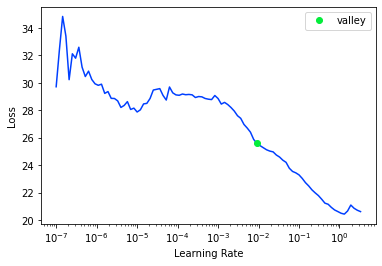

<Figure size 720x720 with 0 Axes>

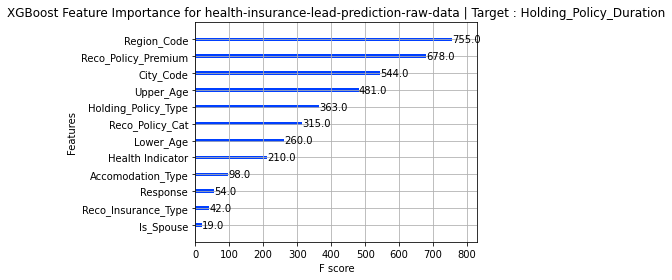

Target Variable: Health Indicator
CATS=====================
['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
CONTS=====================
['Region_Code', 'Reco_Policy_Premium']
13
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Region_Code', 'Reco_Policy_Premium']
Categorical variables that made the cut : ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
Tabular Object size: 2500


  5%|▍         | 2/42 [00:00<00:02, 15.49it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.01897641209747336, 'Adjusted R-Squared': -0.04408466044484438, 'RMSE': 0.4382613122039469, 'Time taken': 0.043287038803100586}
{'Model': 'BaggingRegressor', 'R-Squared': -0.15938799762329148, 'Adjusted R-Squared': -0.1879560797002513, 'RMSE': 0.467482619997792, 'Time taken': 0.08545994758605957}
{'Model': 'BayesianRidge', 'R-Squared': -0.0035447586194672365, 'Adjusted R-Squared': -0.028272760885244663, 'RMSE': 0.4349300780823685, 'Time taken': 0.031197071075439453}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.9629063746710802, 'Adjusted R-Squared': -1.0112736775377185, 'RMSE': 0.6082762530298219, 'Time taken': 0.053191423416137695}
{'Model': 'DummyRegressor', 'R-Squared': -0.0030557677616498413, 'Adjusted R-Squared': -0.027771720971382363, 'RMSE': 0.4348241023678425, 'Time taken': 0.025509357452392578}


 19%|█▉        | 8/42 [00:00<00:01, 22.58it/s]

{'Model': 'ElasticNet', 'R-Squared': -0.0030557677616498413, 'Adjusted R-Squared': -0.027771720971382363, 'RMSE': 0.4348241023678425, 'Time taken': 0.02126479148864746}
{'Model': 'ElasticNetCV', 'R-Squared': -0.0030557677616498413, 'Adjusted R-Squared': -0.027771720971382363, 'RMSE': 0.4348241023678425, 'Time taken': 0.08047080039978027}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -1.164502164502164, 'Adjusted R-Squared': -1.2178369200956465, 'RMSE': 0.6387487769068525, 'Time taken': 0.014186620712280273}
{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.11688311688311659, 'Adjusted R-Squared': -0.14440385076935347, 'RMSE': 0.45883330306332387, 'Time taken': 0.3903181552886963}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 26%|██▌       | 11/42 [00:01<00:03,  7.81it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.8806904200513008, 'Adjusted R-Squared': -1.9516725248574929, 'RMSE': 0.7368844016655463, 'Time taken': 0.3417510986328125}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.03423001367977352, 'Adjusted R-Squared': -0.05971412079303273, 'RMSE': 0.44152941086476066, 'Time taken': 0.2997252941131592}


 36%|███▌      | 15/42 [00:01<00:03,  6.90it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.13224070923273823, 'Adjusted R-Squared': -0.16013986428570082, 'RMSE': 0.46197710411613935, 'Time taken': 0.32433319091796875}
{'Model': 'HuberRegressor', 'R-Squared': -0.33678917041171075, 'Adjusted R-Squared': -0.3697285339536829, 'RMSE': 0.5019755088307853, 'Time taken': 0.08354020118713379}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.26559714795008893, 'Adjusted R-Squared': -0.2967822932794544, 'RMSE': 0.4884260435316692, 'Time taken': 0.028765439987182617}


 40%|████      | 17/42 [00:02<00:03,  7.81it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.3444278913238994, 'Adjusted R-Squared': -0.3775554779684307, 'RMSE': 0.5034076676044871, 'Time taken': 0.1472635269165039}
{'Model': 'Lars', 'R-Squared': -0.01245988303063128, 'Adjusted R-Squared': -0.03740755981988708, 'RMSE': 0.43685768633702887, 'Time taken': 0.02266407012939453}
{'Model': 'LarsCV', 'R-Squared': -0.0030557677616498413, 'Adjusted R-Squared': -0.027771720971382363, 'RMSE': 0.4348241023678425, 'Time taken': 0.04784870147705078}
{'Model': 'Lasso', 'R-Squared': -0.0030557677616498413, 'Adjusted R-Squared': -0.027771720971382363, 'RMSE': 0.4348241023678425, 'Time taken': 0.017090320587158203}


 48%|████▊     | 20/42 [00:02<00:02,  9.43it/s]

{'Model': 'LassoCV', 'R-Squared': -0.0030557677616498413, 'Adjusted R-Squared': -0.027771720971382363, 'RMSE': 0.4348241023678425, 'Time taken': 0.13738727569580078}
{'Model': 'LassoLars', 'R-Squared': -0.0030557677616498413, 'Adjusted R-Squared': -0.027771720971382363, 'RMSE': 0.4348241023678425, 'Time taken': 0.011267662048339844}
{'Model': 'LassoLarsCV', 'R-Squared': -0.0030557677616498413, 'Adjusted R-Squared': -0.027771720971382363, 'RMSE': 0.4348241023678425, 'Time taken': 0.0291140079498291}
{'Model': 'LassoLarsIC', 'R-Squared': -0.0030557677616498413, 'Adjusted R-Squared': -0.027771720971382363, 'RMSE': 0.4348241023678425, 'Time taken': 0.015109539031982422}
{'Model': 'LinearRegression', 'R-Squared': -0.01245988303063128, 'Adjusted R-Squared': -0.03740755981988708, 'RMSE': 0.43685768633702887, 'Time taken': 0.011352300643920898}
{'Model': 'LinearSVR', 'R-Squared': -0.33689820605279497, 'Adjusted R-Squared': -0.36984025630460904, 'RMSE': 0.5019959803107269, 'Time taken': 0.01937

 62%|██████▏   | 26/42 [00:03<00:03,  4.93it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.17106038354208675, 'Adjusted R-Squared': -0.19991608087782597, 'RMSE': 0.46982996717551895, 'Time taken': 1.655418872833252}


 67%|██████▋   | 28/42 [00:04<00:02,  4.88it/s]

{'Model': 'NuSVR', 'R-Squared': -0.30630451152459437, 'Adjusted R-Squared': -0.3384927130406008, 'RMSE': 0.4962188783232052, 'Time taken': 0.4152951240539551}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.007077631222717207, 'Adjusted R-Squared': -0.031892685790833264, 'RMSE': 0.4356949680395188, 'Time taken': 0.010680198669433594}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.007077631222717207, 'Adjusted R-Squared': -0.031892685790833264, 'RMSE': 0.4356949680395188, 'Time taken': 0.018373966217041016}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.7254294324200254, 'Adjusted R-Squared': -0.7679451473872538, 'RMSE': 0.5702951396368772, 'Time taken': 0.010040044784545898}
{'Model': 'PoissonRegressor', 'R-Squared': -0.004783375212885188, 'Adjusted R-Squared': -0.02954189780539984, 'RMSE': 0.4351983996915982, 'Time taken': 0.012069940567016602}


 79%|███████▊  | 33/42 [00:42<00:28,  3.17s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.33689839572983193, 'Adjusted R-Squared': -0.36984045065541293, 'RMSE': 0.5019960159219299, 'Time taken': 37.73283267021179}
{'Model': 'RANSACRegressor', 'R-Squared': -0.3368983957219249, 'Adjusted R-Squared': -0.36984045064731097, 'RMSE': 0.5019960159204453, 'Time taken': 0.15752410888671875}


 81%|████████  | 34/42 [00:43<00:22,  2.83s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.08106697224344273, 'Adjusted R-Squared': -0.10770517279153569, 'RMSE': 0.45141643744994486, 'Time taken': 0.7663149833679199}
{'Model': 'Ridge', 'R-Squared': -0.012443630250596804, 'Adjusted R-Squared': -0.03739090656067301, 'RMSE': 0.4368541799361848, 'Time taken': 0.010611295700073242}
{'Model': 'RidgeCV', 'R-Squared': -0.01230883261006488, 'Adjusted R-Squared': -0.0372527874177051, 'RMSE': 0.4368250973921563, 'Time taken': 0.018317699432373047}
{'Model': 'SGDRegressor', 'R-Squared': -0.006394363235414202, 'Adjusted R-Squared': -0.031192581631358518, 'RMSE': 0.4355471408383054, 'Time taken': 0.012573003768920898}


 90%|█████████ | 38/42 [00:43<00:06,  1.60s/it]

{'Model': 'SVR', 'R-Squared': -0.13503923943688756, 'Adjusted R-Squared': -0.16300735211295048, 'RMSE': 0.4625476802199916, 'Time taken': 0.2646191120147705}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.01245988303063128, 'Adjusted R-Squared': -0.03740755981988708, 'RMSE': 0.43685768633702887, 'Time taken': 0.011444330215454102}
{'Model': 'TweedieRegressor', 'R-Squared': -0.007482060996677697, 'Adjusted R-Squared': -0.032307080980168656, 'RMSE': 0.43578244408148176, 'Time taken': 0.014366865158081055}


100%|██████████| 42/42 [00:44<00:00,  1.07s/it]

{'Model': 'XGBRegressor', 'R-Squared': -0.27273469497314284, 'Adjusted R-Squared': -0.3040957141511258, 'RMSE': 0.48980138, 'Time taken': 1.2959330081939697}
{'Model': 'LGBMRegressor', 'R-Squared': -0.12109572405141567, 'Adjusted R-Squared': -0.14872025934631705, 'RMSE': 0.4596977915987803, 'Time taken': 0.10999917984008789}
Project: health-insurance-lead-prediction-raw-data
health-insurance-lead-prediction-raw-data
Target: Health Indicator
Health Indicator
Target Standard Deviation: 0.41954260808647315
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsCV                                 -0.03      -0.00  0.43        0.03
ElasticNetCV                                -0.03      -0.00  0.43        0.08
LassoCV                                     -0.03      -0.00  0.43        0.14
Lasso                                       -0.03      -0.00  0.43        0.02
LarsCV           

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.45253831148147583.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       0       0.25
1       0       0.54
2       0       0.31
3       1       0.06
4       0       0.36
XGBoost RMSE:  0.48995876


<Figure size 432x288 with 0 Axes>

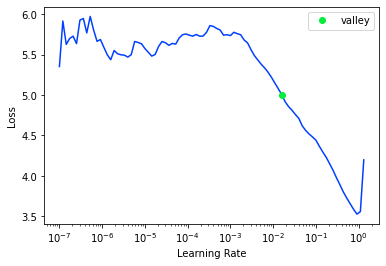

<Figure size 720x720 with 0 Axes>

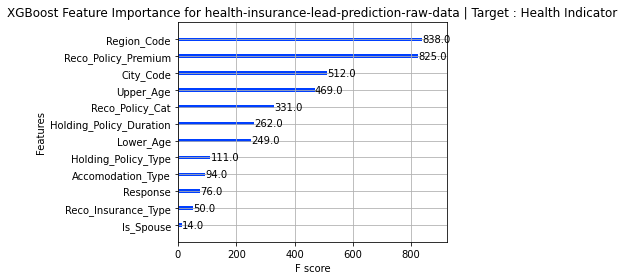

Target Variable: Is_Spouse
CATS=====================
['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
CONTS=====================
['Region_Code', 'Reco_Policy_Premium']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Region_Code', 'Reco_Policy_Premium']
Categorical variables that made the cut : ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
Tabular Object size: 2500


  0%|          | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BaggingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BayesianRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DecisionTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').


 81%|████████  | 34/42 [00:00<00:00, 161.78it/s]

DummyRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNet model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNetCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreesRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GammaRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GaussianProcessRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HistGradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a 

100%|██████████| 42/42 [00:00<00:00, 153.35it/s]


SVR model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TransformedTargetRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TweedieRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
XGBRegressor model failed to execute
[20:06:45] ../src/data/data.cc:458: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x16b9c9) [0x7fb8e99779c9]
  [bt] (1) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x178eb6) [0x7fb8e9984eb6]
  [bt] (2) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x179d10) [0x7fb8e9985d10]
  [bt] (3) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0xa4) [0x7fb8e98c8754]
  [bt] (4) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.8

LEARNING RATE: 0.1


Traceback (most recent call last):
  File "/tmp/ipykernel_20/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost failed
Target Variable: Lower_Age
CATS=====================
['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
CONTS=====================
['Region_Code', 'Is_Spouse', 'Reco_Policy_Premium']
13
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Region_Code', 'Is_Spouse', 'Reco_Policy_Premium']
Categorical variables that made the cut : ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response', 'Is_Spouse_na']


Traceback (most recent call last):
  File "/tmp/ipykernel_20/2755408106.py", line 304, in <module>
    xgb.fit(X_train, y_train)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 946, in fit
    enable_categorical=self.enable_categorical,
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 410, in _wrap_evaluation_matrices
    enable_categorical=enable_categorical,
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 945, in <lambda>
    create_dmatrix=lambda **kwargs: DMatrix(nthread=self.n_jobs, **kwargs),
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 705, in __init__
    feature_weights=feature_weights,
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 575, in in

Tabular Object size: 2500


  2%|▏         | 1/42 [00:00<00:06,  6.23it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7977433189675018, 'Adjusted R-Squared': 0.7923331608328876, 'RMSE': 7.988728984179383, 'Time taken': 0.16031551361083984}


 10%|▉         | 4/42 [00:00<00:02, 16.01it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.872626234982012, 'Adjusted R-Squared': 0.8692191178107489, 'RMSE': 6.339664028952954, 'Time taken': 0.05940723419189453}
{'Model': 'BayesianRidge', 'R-Squared': 0.8724370958935861, 'Adjusted R-Squared': 0.8690249194462951, 'RMSE': 6.344369210876972, 'Time taken': 0.018404483795166016}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7695749455746467, 'Adjusted R-Squared': 0.7634113124315817, 'RMSE': 8.52689861555771, 'Time taken': 0.0394442081451416}
{'Model': 'DummyRegressor', 'R-Squared': -0.0037860628932744333, 'Adjusted R-Squared': -0.030636307373958838, 'RMSE': 17.797001236163357, 'Time taken': 0.026634693145751953}
{'Model': 'ElasticNet', 'R-Squared': 0.7417329341729808, 'Adjusted R-Squared': 0.7348245558689659, 'RMSE': 9.027360046560332, 'Time taken': 0.02454543113708496}


 17%|█▋        | 7/42 [00:00<00:02, 15.30it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.8703639302840049, 'Adjusted R-Squared': 0.8668962987895441, 'RMSE': 6.395716102691843, 'Time taken': 0.1459178924560547}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7818206738342546, 'Adjusted R-Squared': 0.7759846013236482, 'RMSE': 8.297228452923301, 'Time taken': 0.02944159507751465}


 21%|██▏       | 9/42 [00:00<00:03,  9.81it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8804819450871374, 'Adjusted R-Squared': 0.8772849600791801, 'RMSE': 6.141055300190676, 'Time taken': 0.3152933120727539}
{'Model': 'GammaRegressor', 'R-Squared': 0.645235920147597, 'Adjusted R-Squared': 0.6357463459951664, 'RMSE': 10.580253423523075, 'Time taken': 0.01996612548828125}


 26%|██▌       | 11/42 [00:01<00:04,  7.53it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.532724083799713, 'Adjusted R-Squared': 0.5202249337778946, 'RMSE': 12.142635228016179, 'Time taken': 0.3714132308959961}


 29%|██▊       | 12/42 [00:01<00:04,  6.02it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8905388064621704, 'Adjusted R-Squared': 0.8876108321494302, 'RMSE': 5.877008780076864, 'Time taken': 0.30764222145080566}


 36%|███▌      | 15/42 [00:02<00:04,  6.67it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8866216824304851, 'Adjusted R-Squared': 0.8835889290798602, 'RMSE': 5.981240343754244, 'Time taken': 0.3489062786102295}
{'Model': 'HuberRegressor', 'R-Squared': 0.8244426134925141, 'Adjusted R-Squared': 0.819746634018034, 'RMSE': 7.442790650049249, 'Time taken': 0.08531451225280762}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7714247350856632, 'Adjusted R-Squared': 0.7653105819089423, 'RMSE': 8.492603840990112, 'Time taken': 0.03166651725769043}


 48%|████▊     | 20/42 [00:02<00:02, 10.96it/s]

{'Model': 'KernelRidge', 'R-Squared': -1.4620481101422271, 'Adjusted R-Squared': -1.5279053641172249, 'RMSE': 27.872409720996792, 'Time taken': 0.1492922306060791}
{'Model': 'Lars', 'R-Squared': 0.8724703174745378, 'Adjusted R-Squared': 0.8690590296703589, 'RMSE': 6.343543015748182, 'Time taken': 0.02944326400756836}
{'Model': 'LarsCV', 'R-Squared': 0.8720858937004452, 'Adjusted R-Squared': 0.8686643229558069, 'RMSE': 6.353096767220622, 'Time taken': 0.05472207069396973}
{'Model': 'Lasso', 'R-Squared': 0.8563479607104694, 'Adjusted R-Squared': 0.8525054164496383, 'RMSE': 6.732589690391927, 'Time taken': 0.011570215225219727}
{'Model': 'LassoCV', 'R-Squared': 0.8721347307134872, 'Adjusted R-Squared': 0.868714466308704, 'RMSE': 6.351883859985975, 'Time taken': 0.07338857650756836}
{'Model': 'LassoLars', 'R-Squared': -0.0037860628932744333, 'Adjusted R-Squared': -0.030636307373958838, 'RMSE': 17.797001236163357, 'Time taken': 0.013543367385864258}


 60%|█████▉    | 25/42 [00:02<00:00, 17.41it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.8720858937004452, 'Adjusted R-Squared': 0.8686643229558069, 'RMSE': 6.353096767220622, 'Time taken': 0.030636072158813477}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8719264843562544, 'Adjusted R-Squared': 0.8685006495756604, 'RMSE': 6.3570542183938965, 'Time taken': 0.014388084411621094}
{'Model': 'LinearRegression', 'R-Squared': 0.8724703174745378, 'Adjusted R-Squared': 0.8690590296703589, 'RMSE': 6.343543015748182, 'Time taken': 0.01503896713256836}
{'Model': 'LinearSVR', 'R-Squared': 0.8244588789890449, 'Adjusted R-Squared': 0.819763334599863, 'RMSE': 7.4424458525670065, 'Time taken': 0.0375828742980957}
{'Model': 'MLPRegressor', 'R-Squared': 0.8778389749340099, 'Adjusted R-Squared': 0.8745712931935615, 'RMSE': 6.20858432434734, 'Time taken': 1.5945947170257568}
{'Model': 'NuSVR', 'R-Squared': 0.8200459940155601, 'Adjusted R-Squared': 0.8152324094933425, 'RMSE': 7.535412120948515, 'Time taken': 0.1965317726135254}


 67%|██████▋   | 28/42 [00:04<00:03,  4.55it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.7866133207775968, 'Adjusted R-Squared': 0.7809054466420181, 'RMSE': 8.205591683360373, 'Time taken': 0.012670755386352539}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8722145199059663, 'Adjusted R-Squared': 0.8687963897799942, 'RMSE': 6.349901731549959, 'Time taken': 0.019090652465820312}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8470648243285934, 'Adjusted R-Squared': 0.842973965720099, 'RMSE': 6.946722380651929, 'Time taken': 0.014508724212646484}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8303281666327517, 'Adjusted R-Squared': 0.8257896196496771, 'RMSE': 7.31696750292238, 'Time taken': 0.01692795753479004}


 76%|███████▌  | 32/42 [00:54<00:46,  4.64s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.04075379632592524, 'Adjusted R-Squared': -0.06859288964328547, 'RMSE': 18.121754881919763, 'Time taken': 49.715813398361206}
{'Model': 'RANSACRegressor', 'R-Squared': 0.8606268121158651, 'Adjusted R-Squared': 0.8568987227280178, 'RMSE': 6.6315624961233395, 'Time taken': 0.02341771125793457}


 81%|████████  | 34/42 [00:54<00:29,  3.75s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8792341579859433, 'Adjusted R-Squared': 0.8760037959567607, 'RMSE': 6.173028851382439, 'Time taken': 0.5387082099914551}
{'Model': 'Ridge', 'R-Squared': 0.8724385765343567, 'Adjusted R-Squared': 0.8690264396926831, 'RMSE': 6.344332390772249, 'Time taken': 0.011029720306396484}
{'Model': 'RidgeCV', 'R-Squared': 0.8724385765344314, 'Adjusted R-Squared': 0.8690264396927597, 'RMSE': 6.344332390770393, 'Time taken': 0.01805281639099121}
{'Model': 'SGDRegressor', 'R-Squared': 0.872021371364269, 'Adjusted R-Squared': 0.868598074713519, 'RMSE': 6.354698877331086, 'Time taken': 0.04512906074523926}


 90%|█████████ | 38/42 [00:54<00:09,  2.39s/it]

{'Model': 'SVR', 'R-Squared': 0.8238057576282392, 'Adjusted R-Squared': 0.8190927429145912, 'RMSE': 7.456278245265734, 'Time taken': 0.26331305503845215}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8724703174745378, 'Adjusted R-Squared': 0.8690590296703589, 'RMSE': 6.343543015748182, 'Time taken': 0.015304088592529297}
{'Model': 'TweedieRegressor', 'R-Squared': 0.6612886741628609, 'Adjusted R-Squared': 0.6522284946651595, 'RMSE': 10.338109058896602, 'Time taken': 0.020930767059326172}


 98%|█████████▊| 41/42 [00:55<00:01,  1.76s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.8741868104929357, 'Adjusted R-Squared': 0.8708214371110594, 'RMSE': 6.300708, 'Time taken': 0.48073434829711914}


100%|██████████| 42/42 [00:55<00:00,  1.33s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.8876230406163936, 'Adjusted R-Squared': 0.8846170725670379, 'RMSE': 5.95476858372077, 'Time taken': 0.2411179542541504}
Project: health-insurance-lead-prediction-raw-data
health-insurance-lead-prediction-raw-data
Target: Lower_Age
Lower_Age
Target Standard Deviation: 17.527633924748656
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.89       0.89  5.88        0.31
LGBMRegressor                                0.88       0.89  5.95        0.24
HistGradientBoostingRegressor                0.88       0.89  5.98        0.35
ExtraTreesRegressor                          0.88       0.88  6.14        0.32
RandomForestRegressor                        0.88       0.88  6.17        0.54
MLPRegressor                                 0.87       0.88  6.21        1.59
XGBRegressor                           

LEARNING RATE: 0.1


Could not fit model


Traceback (most recent call last):
  File "/tmp/ipykernel_20/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

XGBoost Predictions vs Actual==========
   actual  predicted
0      40      45.77
1       8       8.11
2       8       7.93
3      60      59.18
4       9       8.36
XGBoost RMSE:  6.305001


<Figure size 432x288 with 0 Axes>

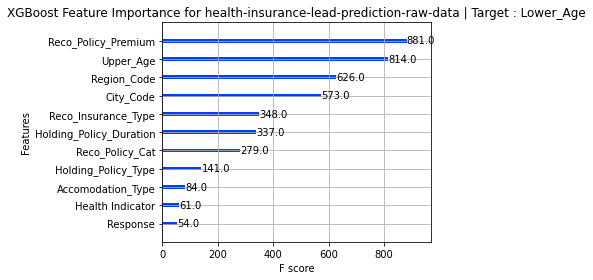

Target Variable: Upper_Age
CATS=====================
['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
CONTS=====================
['Region_Code', 'Is_Spouse', 'Reco_Policy_Premium']
13
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Region_Code', 'Is_Spouse', 'Reco_Policy_Premium']
Categorical variables that made the cut : ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response', 'Is_Spouse_na']
Tabular Object size: 2500


 10%|▉         | 4/42 [00:00<00:01, 19.44it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9455616905204667, 'Adjusted R-Squared': 0.9441055217483804, 'RMSE': 4.212954682942656, 'Time taken': 0.11443090438842773}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9676370165608396, 'Adjusted R-Squared': 0.9667713400490925, 'RMSE': 3.248319565560014, 'Time taken': 0.06435585021972656}
{'Model': 'BayesianRidge', 'R-Squared': 0.9302690893466126, 'Adjusted R-Squared': 0.9284038592262545, 'RMSE': 4.768119606430247, 'Time taken': 0.022540807723999023}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9574038092870394, 'Adjusted R-Squared': 0.9562644050087091, 'RMSE': 3.726660703632677, 'Time taken': 0.022205591201782227}
{'Model': 'DummyRegressor', 'R-Squared': -0.00423454534872425, 'Adjusted R-Squared': -0.03109678627369017, 'RMSE': 18.094727657524995, 'Time taken': 0.011904001235961914}
{'Model': 'ElasticNet', 'R-Squared': 0.8610000739034993, 'Adjusted R-Squared': 0.8572819688844571, 'RMSE': 6.731963570950951, 'Time taken': 0.01167607307434

 17%|█▋        | 7/42 [00:00<00:01, 23.81it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9301062937456739, 'Adjusted R-Squared': 0.9282367090104758, 'RMSE': 4.773682249786238, 'Time taken': 0.07618260383605957}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9515824116795222, 'Adjusted R-Squared': 0.9502872910042831, 'RMSE': 3.973159951474393, 'Time taken': 0.014529228210449219}


 24%|██▍       | 10/42 [00:00<00:02, 13.15it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9729873036115632, 'Adjusted R-Squared': 0.9722647417740123, 'RMSE': 2.967689370537287, 'Time taken': 0.3274390697479248}
{'Model': 'GammaRegressor', 'R-Squared': 0.7459544835183871, 'Adjusted R-Squared': 0.7391590273162041, 'RMSE': 9.101023585476144, 'Time taken': 0.016331911087036133}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.53176211525324, 'Adjusted R-Squared': 0.5192372335624831, 'RMSE': 12.355711156727217, 'Time taken': 0.3680140972137451}


 29%|██▊       | 12/42 [00:01<00:04,  6.67it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9728594179614755, 'Adjusted R-Squared': 0.9721334353143545, 'RMSE': 2.974706010877896, 'Time taken': 0.28626012802124023}


 33%|███▎      | 14/42 [00:01<00:04,  5.96it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9697326241920031, 'Adjusted R-Squared': 0.9689230030284147, 'RMSE': 3.1413900011205445, 'Time taken': 0.3421299457550049}
{'Model': 'HuberRegressor', 'R-Squared': 0.8545470850363839, 'Adjusted R-Squared': 0.8506563692040238, 'RMSE': 6.8864545751274076, 'Time taken': 0.07702445983886719}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8762372095490648, 'Adjusted R-Squared': 0.8729266822324759, 'RMSE': 6.352278331433534, 'Time taken': 0.03672003746032715}


 45%|████▌     | 19/42 [00:02<00:02,  9.70it/s]

{'Model': 'KernelRidge', 'R-Squared': -1.4954221986550649, 'Adjusted R-Squared': -1.5621721751622992, 'RMSE': 28.523741344970443, 'Time taken': 0.15337848663330078}
{'Model': 'Lars', 'R-Squared': 0.9302777463976815, 'Adjusted R-Squared': 0.928412747844533, 'RMSE': 4.767823617637159, 'Time taken': 0.02265334129333496}
{'Model': 'LarsCV', 'R-Squared': 0.9306695913109232, 'Adjusted R-Squared': 0.9288150742060713, 'RMSE': 4.754406956068396, 'Time taken': 0.05854606628417969}
{'Model': 'Lasso', 'R-Squared': 0.9247759418614868, 'Adjusted R-Squared': 0.922763775697288, 'RMSE': 4.952367352009763, 'Time taken': 0.021445035934448242}


 57%|█████▋    | 24/42 [00:02<00:01, 13.11it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9306308478397983, 'Adjusted R-Squared': 0.9287752943869534, 'RMSE': 4.755735208022689, 'Time taken': 0.13536834716796875}
{'Model': 'LassoLars', 'R-Squared': -0.00423454534872425, 'Adjusted R-Squared': -0.03109678627369017, 'RMSE': 18.094727657524995, 'Time taken': 0.026559114456176758}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9306695913109232, 'Adjusted R-Squared': 0.9288150742060713, 'RMSE': 4.754406956068396, 'Time taken': 0.05534029006958008}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9306712516351422, 'Adjusted R-Squared': 0.928816778942255, 'RMSE': 4.754350026472665, 'Time taken': 0.03153419494628906}
{'Model': 'LinearRegression', 'R-Squared': 0.9302777463976815, 'Adjusted R-Squared': 0.928412747844533, 'RMSE': 4.767823617637161, 'Time taken': 0.02463221549987793}
{'Model': 'LinearSVR', 'R-Squared': 0.844613482787965, 'Adjusted R-Squared': 0.8404570533152151, 'RMSE': 7.117723921946035, 'Time taken': 0.04258394241333008}


 62%|██████▏   | 26/42 [00:04<00:04,  3.68it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9588888671726336, 'Adjusted R-Squared': 0.9577891866649056, 'RMSE': 3.661121944052828, 'Time taken': 1.6128039360046387}
{'Model': 'NuSVR', 'R-Squared': 0.927948931579499, 'Adjusted R-Squared': 0.9260216396258641, 'RMSE': 4.846795378542871, 'Time taken': 0.1975257396697998}


 67%|██████▋   | 28/42 [00:04<00:03,  4.41it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8209463027757666, 'Adjusted R-Squared': 0.8161568005866411, 'RMSE': 7.640576335644184, 'Time taken': 0.011186599731445312}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9312746997651671, 'Adjusted R-Squared': 0.9294363686889267, 'RMSE': 4.733613506036144, 'Time taken': 0.018856048583984375}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8705988253297894, 'Adjusted R-Squared': 0.8671374770361417, 'RMSE': 6.4953653154664925, 'Time taken': 0.012516975402832031}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8252805562995466, 'Adjusted R-Squared': 0.8206069909330735, 'RMSE': 7.547534235270869, 'Time taken': 0.015400886535644531}


 76%|███████▌  | 32/42 [00:48<00:49,  4.99s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.013732907450320297, 'Adjusted R-Squared': -0.04084921978952649, 'RMSE': 18.180099041259076, 'Time taken': 44.62102508544922}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9281596519772254, 'Adjusted R-Squared': 0.9262379965774392, 'RMSE': 4.839702725353977, 'Time taken': 0.02912139892578125}


 81%|████████  | 34/42 [00:49<00:30,  3.87s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9731166760455169, 'Adjusted R-Squared': 0.9723975747874751, 'RMSE': 2.9605742348402617, 'Time taken': 0.5359673500061035}
{'Model': 'Ridge', 'R-Squared': 0.9302714262040174, 'Adjusted R-Squared': 0.9284062585921906, 'RMSE': 4.76803970994776, 'Time taken': 0.014158010482788086}
{'Model': 'RidgeCV', 'R-Squared': 0.9302020743068586, 'Adjusted R-Squared': 0.9283350516031327, 'RMSE': 4.770410261938903, 'Time taken': 0.020705223083496094}
{'Model': 'SGDRegressor', 'R-Squared': 0.9302218052241722, 'Adjusted R-Squared': 0.928355310302185, 'RMSE': 4.769735949469245, 'Time taken': 0.042942047119140625}


 90%|█████████ | 38/42 [00:49<00:09,  2.34s/it]

{'Model': 'SVR', 'R-Squared': 0.933904660926441, 'Adjusted R-Squared': 0.9321366786055433, 'RMSE': 4.642157700545026, 'Time taken': 0.24281573295593262}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9302777463976815, 'Adjusted R-Squared': 0.928412747844533, 'RMSE': 4.767823617637161, 'Time taken': 0.015176773071289062}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7899250372978256, 'Adjusted R-Squared': 0.7843057481720472, 'RMSE': 8.276021687397348, 'Time taken': 0.012319803237915039}


100%|██████████| 42/42 [00:50<00:00,  1.20s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9677665425153594, 'Adjusted R-Squared': 0.9669043306896385, 'RMSE': 3.2418127, 'Time taken': 0.46783995628356934}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9695254944118719, 'Adjusted R-Squared': 0.9687103327397615, 'RMSE': 3.1521204658250532, 'Time taken': 0.11971640586853027}
Project: health-insurance-lead-prediction-raw-data
health-insurance-lead-prediction-raw-data
Target: Upper_Age
Upper_Age
Target Standard Deviation: 17.29345306756288
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                        0.97       0.97  2.96        0.54
ExtraTreesRegressor                          0.97       0.97  2.97        0.33
GradientBoostingRegressor                    0.97       0.97  2.97        0.29
HistGradientBoostingRegressor                0.97       0.97  3.14        0.34
LGBMRegressor                           

LEARNING RATE: 0.1


Traceback (most recent call last):
  File "/tmp/ipykernel_20/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost Predictions vs Actual==========
   actual  predicted
0       5       6.06
1      22      24.11
2      50      49.44
3      34      34.28
4      10      10.01
XGBoost RMSE:  3.238279


<Figure size 432x288 with 0 Axes>

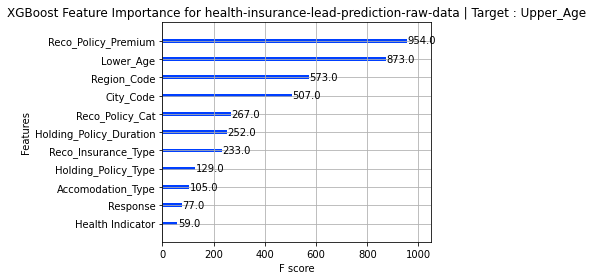

Target Variable: Reco_Insurance_Type
CATS=====================
['City_Code', 'Accomodation_Type', 'Upper_Age', 'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
CONTS=====================
['Region_Code', 'Is_Spouse', 'Reco_Policy_Premium']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Region_Code', 'Is_Spouse', 'Reco_Policy_Premium']
Categorical variables that made the cut : ['City_Code', 'Accomodation_Type', 'Upper_Age', 'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response', 'Is_Spouse_na']
Tabular Object size: 2500


 76%|███████▌  | 32/42 [00:00<00:00, 155.16it/s]

AdaBoostRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BaggingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BayesianRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DecisionTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DummyRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNet model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNetCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreesRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype

100%|██████████| 42/42 [00:00<00:00, 149.25it/s]


RANSACRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RandomForestRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Ridge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RidgeCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SGDRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SVR model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TransformedTargetRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TweedieRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
XGBRegressor model failed to execute
[20:08:33] ../src/data/data.cc:458: Check failed: valid: Label contains NaN, infin

LEARNING RATE: 0.1


Traceback (most recent call last):
  File "/tmp/ipykernel_20/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost failed
Target Variable: Accomodation_Type
CATS=====================
['City_Code', 'Upper_Age', 'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
CONTS=====================
['Region_Code', 'Reco_Insurance_Type', 'Is_Spouse', 'Reco_Policy_Premium']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Region_Code', 'Reco_Insurance_Type', 'Is_Spouse', 'Reco_Policy_Premium']
Categorical variables that made the cut : ['City_Code', 'Upper_Age', 'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response', 'Reco_Insurance_Type_na', 'Is_Spouse_na']
Tabular Object size: 2500


 38%|███▊      | 16/42 [00:00<00:00, 158.83it/s]

AdaBoostRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BaggingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BayesianRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DecisionTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DummyRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNet model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNetCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreesRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype

 76%|███████▌  | 32/42 [00:00<00:00, 153.92it/s]

OrthogonalMatchingPursuit model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
OrthogonalMatchingPursuitCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
PassiveAggressiveRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
PoissonRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
QuantileRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').


100%|██████████| 42/42 [00:00<00:00, 138.79it/s]

RANSACRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RandomForestRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Ridge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RidgeCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SGDRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SVR model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TransformedTargetRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TweedieRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
XGBRegressor model failed to execute
[20:08:34] ../src/data/data.cc:458: Check failed: valid: Label contains NaN, infin

LEARNING RATE: 0.1


Could not fit model


Traceback (most recent call last):
  File "/tmp/ipykernel_20/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

XGBoost failed
Target Variable: Region_Code
CATS=====================
['City_Code', 'Upper_Age', 'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']
CONTS=====================
['Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Reco_Policy_Premium']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Reco_Policy_Premium']
Categorical variables that made the cut : ['City_Code', 'Upper_Age', 'Lower_Age', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response', 'Accomodation_Type_na', 'Reco_Insurance_Type_na', 'Is_Spouse_na']
Tabular Object size: 2500


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.03941571057168769, 'Adjusted R-Squared': -0.0716290073869259, 'RMSE': 1451.8669465551645, 'Time taken': 0.058049917221069336}


  5%|▍         | 2/42 [00:00<00:02, 14.17it/s]

{'Model': 'BaggingRegressor', 'R-Squared': -0.05959817021245217, 'Adjusted R-Squared': -0.092436956479367, 'RMSE': 1465.894716615078, 'Time taken': 0.0828859806060791}
{'Model': 'BayesianRidge', 'R-Squared': -0.006810475076987066, 'Adjusted R-Squared': -0.038013279056645644, 'RMSE': 1428.913839141985, 'Time taken': 0.029422283172607422}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.7351063486011238, 'Adjusted R-Squared': -0.7888803056858693, 'RMSE': 1875.8375670617113, 'Time taken': 0.024456024169921875}
{'Model': 'DummyRegressor', 'R-Squared': -0.00032756635559305636, 'Adjusted R-Squared': -0.03132945374264651, 'RMSE': 1424.305981704774, 'Time taken': 0.01304316520690918}
{'Model': 'ElasticNet', 'R-Squared': -0.0069757308254505546, 'Adjusted R-Squared': -0.03818365636756149, 'RMSE': 1429.0311037825961, 'Time taken': 0.012565135955810547}


 17%|█▋        | 7/42 [00:00<00:01, 23.06it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.0071401290278416685, 'Adjusted R-Squared': -0.038353149555564015, 'RMSE': 1429.1477503658148, 'Time taken': 0.09323596954345703}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.9742031787528411, 'Adjusted R-Squared': -1.035387161565429, 'RMSE': 2000.912526823699, 'Time taken': 0.03200101852416992}


 24%|██▍       | 10/42 [00:00<00:03, 10.19it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.06038466382406371, 'Adjusted R-Squared': -0.09324782489299133, 'RMSE': 1466.4386506278397, 'Time taken': 0.48349547386169434}
{'Model': 'GammaRegressor', 'R-Squared': -0.004681106044661432, 'Adjusted R-Squared': -0.03581791718240912, 'RMSE': 1427.4019878795543, 'Time taken': 0.016191482543945312}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -204.1882092556876, 'Adjusted R-Squared': -210.5473479722895, 'RMSE': 20398.976627648964, 'Time taken': 0.3757610321044922}


 29%|██▊       | 12/42 [00:01<00:04,  6.27it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.07504119614451832, 'Adjusted R-Squared': 0.04637511751263357, 'RMSE': 1369.598825594728, 'Time taken': 0.26266956329345703}


 38%|███▊      | 16/42 [00:02<00:03,  6.98it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.054588229496159935, 'Adjusted R-Squared': 0.025288277930958336, 'RMSE': 1384.6585197969061, 'Time taken': 0.3473024368286133}
{'Model': 'HuberRegressor', 'R-Squared': -0.021668401296019324, 'Adjusted R-Squared': -0.0533316781956894, 'RMSE': 1439.4187663438522, 'Time taken': 0.022817373275756836}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.13170835203480546, 'Adjusted R-Squared': -0.16678195798629725, 'RMSE': 1514.9539793934337, 'Time taken': 0.026894330978393555}
{'Model': 'KernelRidge', 'R-Squared': -1.5042043821743616, 'Adjusted R-Squared': -1.5818140221177819, 'RMSE': 2253.5493100116496, 'Time taken': 0.1414332389831543}


 48%|████▊     | 20/42 [00:02<00:02, 10.49it/s]

{'Model': 'Lars', 'R-Squared': -0.010470968112575418, 'Adjusted R-Squared': -0.04178721712432876, 'RMSE': 1431.5090562699268, 'Time taken': 0.015333414077758789}
{'Model': 'LarsCV', 'R-Squared': -0.0058713529476133175, 'Adjusted R-Squared': -0.03704505190260132, 'RMSE': 1428.2472600224996, 'Time taken': 0.02434253692626953}
{'Model': 'Lasso', 'R-Squared': -0.010489967834413916, 'Adjusted R-Squared': -0.04180680568052164, 'RMSE': 1431.5225144230487, 'Time taken': 0.0116424560546875}
{'Model': 'LassoCV', 'R-Squared': -0.006745499149105827, 'Adjusted R-Squared': -0.037946289411991296, 'RMSE': 1428.8677299174196, 'Time taken': 0.09298276901245117}
{'Model': 'LassoLars', 'R-Squared': -0.00033902675221209044, 'Adjusted R-Squared': -0.031341269316846665, 'RMSE': 1424.3141405645588, 'Time taken': 0.020832538604736328}


 55%|█████▍    | 23/42 [00:02<00:01, 12.94it/s]

{'Model': 'LassoLarsCV', 'R-Squared': -0.0058713529476133175, 'Adjusted R-Squared': -0.03704505190260132, 'RMSE': 1428.2472600224996, 'Time taken': 0.05898237228393555}
{'Model': 'LassoLarsIC', 'R-Squared': -0.009208590679884887, 'Adjusted R-Squared': -0.04048571642409615, 'RMSE': 1430.6145874828865, 'Time taken': 0.027546405792236328}
{'Model': 'LinearRegression', 'R-Squared': -0.010470968112575418, 'Adjusted R-Squared': -0.04178721712432876, 'RMSE': 1431.5090562699268, 'Time taken': 0.020778417587280273}
{'Model': 'LinearSVR', 'R-Squared': -0.45994141618421747, 'Adjusted R-Squared': -0.5051875344543895, 'RMSE': 1720.6791419239837, 'Time taken': 0.026493549346923828}


 62%|██████▏   | 26/42 [00:03<00:03,  4.55it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.2685460791076635, 'Adjusted R-Squared': -0.30786052370810757, 'RMSE': 1603.9296042768926, 'Time taken': 1.523383378982544}
{'Model': 'NuSVR', 'R-Squared': -0.008657477648208012, 'Adjusted R-Squared': -0.03991752344309041, 'RMSE': 1430.2239160119332, 'Time taken': 0.19235730171203613}


 67%|██████▋   | 28/42 [00:04<00:02,  5.19it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.004168414355819827, 'Adjusted R-Squared': -0.02669413478604521, 'RMSE': 1421.1015994758627, 'Time taken': 0.011923551559448242}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.010720925985769014, 'Adjusted R-Squared': -0.04204492162582385, 'RMSE': 1431.686099868952, 'Time taken': 0.016867876052856445}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.0491202327454181, 'Adjusted R-Squared': -0.08163428954537943, 'RMSE': 1458.6288899947149, 'Time taken': 0.01488804817199707}
{'Model': 'PoissonRegressor', 'R-Squared': -0.010787992188438622, 'Adjusted R-Squared': -0.04211406632651005, 'RMSE': 1431.733598716016, 'Time taken': 0.016083478927612305}


 76%|███████▌  | 32/42 [01:01<00:58,  5.86s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.043184938574146736, 'Adjusted R-Squared': -0.07551505030681649, 'RMSE': 1454.4970132936417, 'Time taken': 57.59744334220886}
{'Model': 'RANSACRegressor', 'R-Squared': -0.5693770398692382, 'Adjusted R-Squared': -0.6180147580470037, 'RMSE': 1784.004013195783, 'Time taken': 0.0963904857635498}


 81%|████████  | 34/42 [01:02<00:37,  4.66s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.041606747812271805, 'Adjusted R-Squared': 0.011904477599842256, 'RMSE': 1394.1325057566803, 'Time taken': 0.7787289619445801}
{'Model': 'Ridge', 'R-Squared': -0.010480188086393616, 'Adjusted R-Squared': -0.04179672284113711, 'RMSE': 1431.5155871086786, 'Time taken': 0.011391401290893555}
{'Model': 'RidgeCV', 'R-Squared': -0.010557454652504683, 'Adjusted R-Squared': -0.04187638403223093, 'RMSE': 1431.570316622782, 'Time taken': 0.032492876052856445}
{'Model': 'SGDRegressor', 'R-Squared': -0.012601065131940148, 'Adjusted R-Squared': -0.04398332954718609, 'RMSE': 1433.0170896459356, 'Time taken': 0.03780221939086914}


 90%|█████████ | 38/42 [01:02<00:11,  2.89s/it]

{'Model': 'SVR', 'R-Squared': -0.043720242898585226, 'Adjusted R-Squared': -0.07606694464131003, 'RMSE': 1454.8701488013523, 'Time taken': 0.2597024440765381}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.010470968112575418, 'Adjusted R-Squared': -0.04178721712432876, 'RMSE': 1431.5090562699268, 'Time taken': 0.012389421463012695}
{'Model': 'TweedieRegressor', 'R-Squared': -0.004830482514125878, 'Adjusted R-Squared': -0.03597192308791075, 'RMSE': 1427.5080973422182, 'Time taken': 0.019895553588867188}


100%|██████████| 42/42 [01:03<00:00,  1.51s/it]

{'Model': 'XGBRegressor', 'R-Squared': -0.1274540069678276, 'Adjusted R-Squared': -0.1623957633821198, 'RMSE': 1512.1038, 'Time taken': 0.47884511947631836}
{'Model': 'LGBMRegressor', 'R-Squared': 0.0650351984923444, 'Adjusted R-Squared': 0.03605901662743771, 'RMSE': 1376.9869057158562, 'Time taken': 0.11150026321411133}
Project: health-insurance-lead-prediction-raw-data
health-insurance-lead-prediction-raw-data
Target: Region_Code
Region_Code
Target Standard Deviation: 1412.481490285802
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
GradientBoostingRegressor                    0.05       0.08  1369.60   
LGBMRegressor                                0.04       0.07  1376.99   
HistGradientBoostingRegressor                0.03       0.05  1384.66   
RandomForestRegressor                        0.01       0.04  1394.13   
OrthogonalMatchingPursuit                   -0.03       0.00  1421.10

LEARNING RATE: 0.1


Traceback (most recent call last):
  File "/tmp/ipykernel_20/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost Predictions vs Actual==========
   actual  predicted
0     931    1676.57
1     934     529.83
2    3480    1054.13
3      81    3625.75
4    2994    1117.40
XGBoost RMSE:  1511.2983


<Figure size 432x288 with 0 Axes>

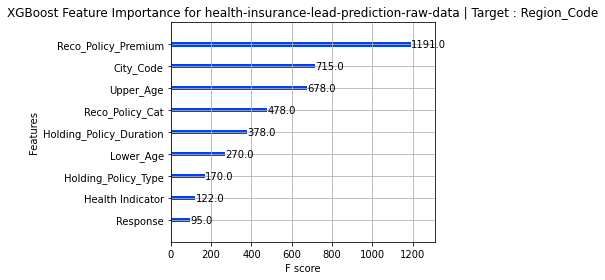

<Figure size 432x288 with 0 Axes>

In [22]:
target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric, errors='coerce').dropna()
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].apply(pd.to_numeric, errors='coerce').dropna()

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

               feature  importance
0            City_Code      512.00
1    Accomodation_Type       94.00
2  Reco_Insurance_Type       50.00
3            Upper_Age      469.00
4            Lower_Age      249.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

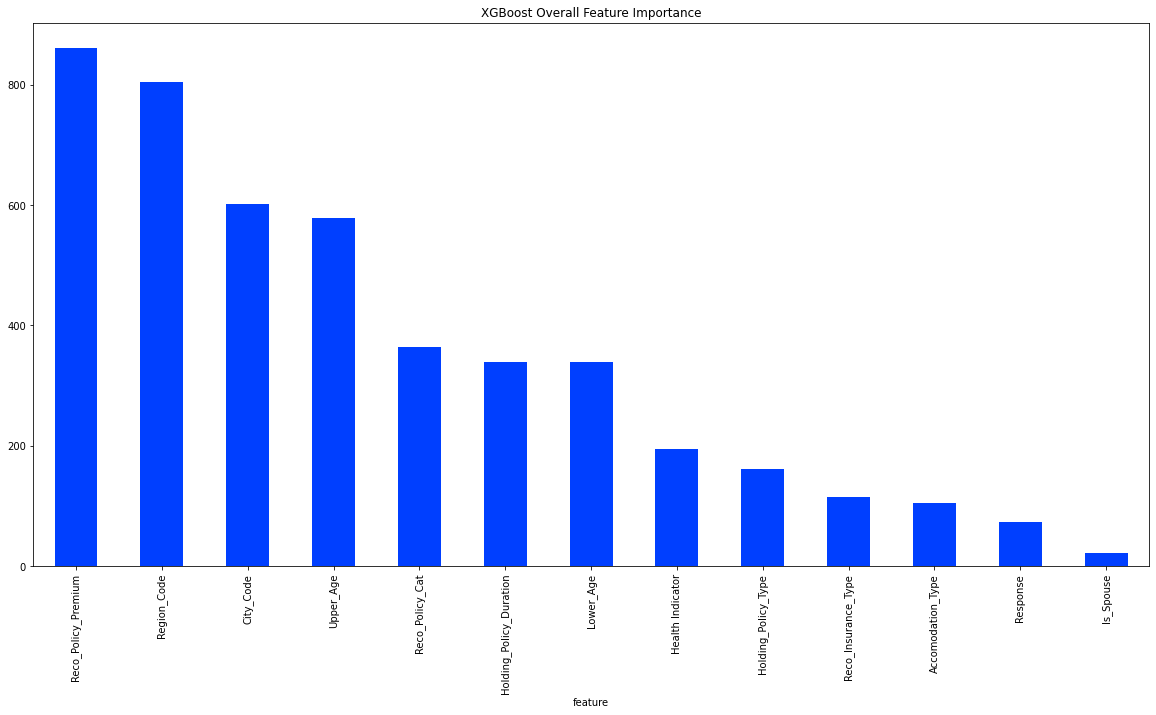

In [23]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [24]:
df.isna().sum()

City_Code                     0
Region_Code                   0
Accomodation_Type          2500
Reco_Insurance_Type        2500
Upper_Age                     0
Lower_Age                     0
Is_Spouse                  2500
Health Indicator           1918
Holding_Policy_Duration     211
Holding_Policy_Type           0
Reco_Policy_Cat               0
Reco_Policy_Premium           0
Response                      0
dtype: int64

# **To Be Continued...**